In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import fftpack
import matplotlib.gridspec as gridspec
import animatplot as amp
from matplotlib.lines import Line2D

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_green = '#708238'

colormap = matplotlib.colormaps.get_cmap('coolwarm')
colormap_aux = matplotlib.colormaps.get_cmap('tab10')

## Basic Ising model

In [3]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1,periodic_boundary=False):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # choose periodic boundary unless specified
    if periodic_boundary == False:
        # remove edges
        left[:,0] = 0.
        right[:,-1] = 0.
        top[0,:] = 0.
        bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

# function to implement Gillespie's algorithm
@numba.jit(nopython=True)
def ising_2d_lig(n_sims,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,periodic_boundary=False):
    # initialise
    state = np.random.choice(np.array([-1.,1.]),size=(L,L))

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state,periodic_boundary=periodic_boundary)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

/tmp/ipykernel_2753169/3556515506.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


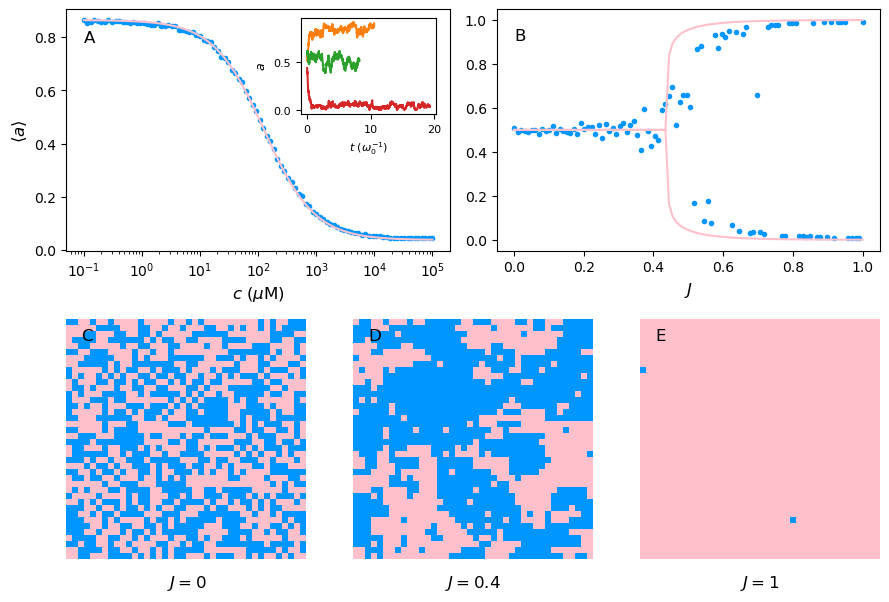

In [12]:
# show benchmark results in one figure
n_sims = 10**4
L = 10

# preparation
fig = plt.figure(figsize=(9,12))

# create subplots
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])

# create inset
left, bottom, width, height = [0.34, 0.9, 0.15, 0.08]
axx = fig.add_axes([left, bottom, width, height])

ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:])

#################
## No coupling ##
#################

# prep
J = 0
c_arr = np.logspace(-1,5,10**2)
all_avg_spin = np.empty(c_arr.size)
color_counter = 1

# loop through various concentrations
for i,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[4000:])
    
    # plot realisations in the inset for some exemplars
    if i % 49 == 0:
        axx.plot(np.cumsum(waiting_times)[:800],0.5 + 0.5*avg_spin[:800],color=colormap_aux(color_counter))
        color_counter += 1
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
ax1.semilogx(c_arr,all_avg_act,'.',label='Simulation',color='#0096FF')
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory',color='#FFC0CB',alpha=1)
ax1.set_xlabel(r'$c$ ($\mu$M)',size=12)
ax1.set_ylabel(r'$\langle a \rangle$',size=12)
ax1.text(10**-1,0.78,'A',size=12)

# inset formatting
axx.set_xlabel(r'$t$ $(\omega_0^{-1})$',size=8)
axx.set_ylabel(r'$a$',size=9)
axx.tick_params(axis='both', which='major', labelsize=8)

######################
## Phase transition ##
######################

# preparation
J_arr = np.linspace(0,1,10**2)
c = 100
all_avg_spin = np.empty(J_arr.size)

# loop through various concentrations
for i,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[4000:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin

# theoretical result for an infinite system
def theoretical_act(J,Jcrit=0.5*np.log(1+np.sqrt(2))):
    return np.piecewise(J, [J < Jcrit, J >= Jcrit], [0.5, lambda J: 0.5 + 0.5*((1 - (np.sinh(2*J))**-4)**(1/8))])

# show results
ax2.plot(J_arr,all_avg_act,'.',label='Simulation',color='#0096FF')
ax2.plot(J_arr,theoretical_act(J_arr),color='#FFC0CB')
ax2.plot(J_arr,1-theoretical_act(J_arr),color='#FFC0CB',alpha=1)
ax2.set_xlabel(r'$J$',size=12)
ax2.text(0,0.91,'B',size=12)

##########################
## Spatial organisation ##
##########################

# formatting
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()

# parameters
n_sims = 5*10**4
L = 40
c = 100
J_list = [0,0.4,1]

# for formatting
text_list = ['C','D','E']
cmap = matplotlib.colors.ListedColormap(['#FFC0CB','#0096FF'])

for i,ax in enumerate((ax3, ax4, ax5)):
    # obtain data and show lattice
    spins,_ = ising_2d_lig(n_sims,L,J_list[i],cbase=c)
    ax.imshow(0.5 + 0.5*spins[-1,:,:],cmap=cmap)
    ax.set_title(f'$J={J_list[i]}$', y=-0.15, size=12)
    ax.text(2,3,text_list[i],size=12)

plt.tight_layout()
plt.margins(x=0,y=0)
plt.show()

In [4]:
# function that implements dynamic Ising model using Gillespie's algorithm
@numba.jit(nopython=True)
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,periodic_boundary=False):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state,periodic_boundary=periodic_boundary)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state,periodic_boundary=periodic_boundary)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

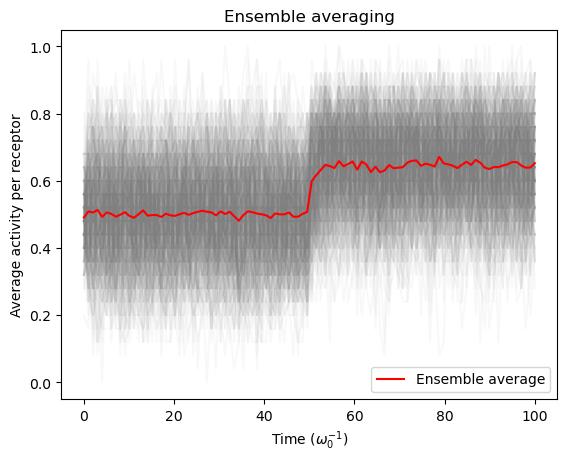

In [156]:
# check whether this works
n_samples = 250
n_steps = 10**2
tf = 100
c = 100
cnew = 70
step_change = 50
L = 5
J = 0.2

# obtain results
all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,cnew=cnew,
                                                          step_change=step_change,periodic_boundary=False)

# convert to activity 
av_act = 0.5*(ensemble_av + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(av_act,axis=(1,2)),color='red',label='Ensemble average')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title('Ensemble averaging')
plt.legend()
plt.show()

## Convergence of MWC and Ising

In [5]:
# self-consistency relation
def scr(m,J,c,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return m-np.tanh(q*J*m + H)

# function for calculating the theoretical ratio based on a mean-field theory
def ratio_mfa(J,c,N,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    # this solves the self-consistency relation
    roots = fsolve(scr,[-1,0,1],args=(J,c))
    
    # extract only the outer two solutions
    m_min = roots[0]
    m_plus = roots[-1]
    
    # calculate ratio using analytical expression if two distinct nonzero sol exist
    if m_min == m_plus:
        return -1
    else:
        prefac = np.exp(-0.5*q*J*(m_min**2 - m_plus**2))
        cosh_ratio = np.cosh(q*J*m_min + H)/np.cosh(q*J*m_plus + H)
    
        return (prefac*cosh_ratio)**N

# theoretical estimate of the desired ratio based on MWC
def mwc_ratio(c,N=6,Ki=18,Ka=2900):
    epsilon0 = -N*np.log((1 + 100/Ki)/(1 + 100/Ka))
    return np.exp(epsilon0)*((1 + c/Ki)/(1 + c/Ka))**N

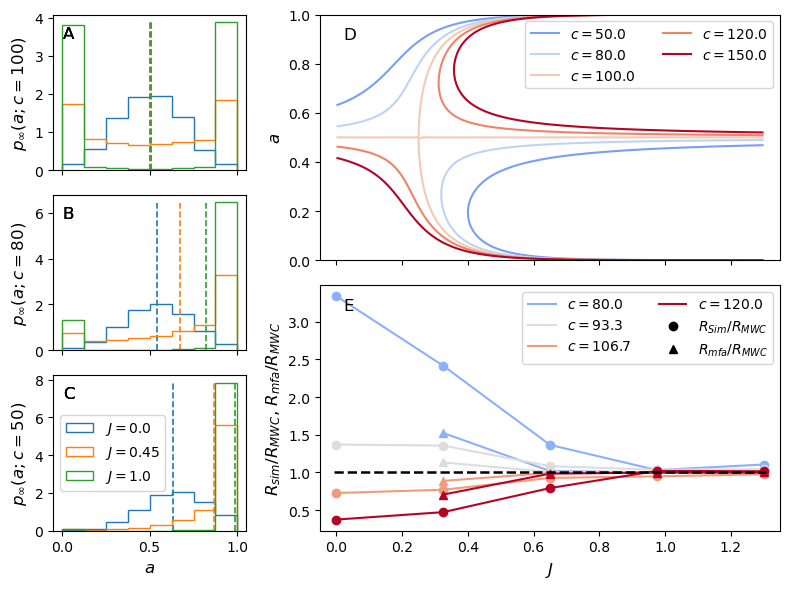

In [16]:
# preparation
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(6, 3)

##############################
## Stationary distributions ##
##############################

ax3 = fig.add_subplot(gs[4:,0])
ax1 = fig.add_subplot(gs[0:2,0],sharex=ax3)
ax2 = fig.add_subplot(gs[2:4,0],sharex=ax3)

colormap_aux = matplotlib.colormaps.get_cmap('tab10')

# parameters
n_samples = 5000
tf = 4000
L = 3
N = L**2
cbase = 100
n_steps = 10**3

J_arr = np.array([0.,0.45,1.])
c_arr = np.array([100.,80.,50.])
text_list = ['A','B','C']

# for various J in absence of external field
for i,ax in enumerate((ax1, ax2, ax3)):
    for j,J in enumerate(J_arr):
        # set concentration and color
        c = c_arr[i]
        color = colormap_aux(j)
        
        # extract an ensemble of states
        all_states,_,time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_states[:,-1,:,:],axis=(1,2))
        
        # plot distributions along with mean
        ax.hist(last_act,bins=8,density=True,histtype='step',color=color,label=f'$J={J}$')
        ax.axvline(x=np.mean(last_act),ymin=0.0,ymax=0.95,ls='--',color=color,linewidth=1.2)
        ax.text(0.05,0.85,text_list[i],size=12,transform = ax.transAxes)
        
    ax.set_ylabel(r'$p_\infty(a; c = '+str(int(c))+')$',size=12)

# formatting
ax3.legend(fontsize=10,loc='center left')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.set_xlabel(r'$a$',size=12)

#########################
## Bifurcation diagram ##
#########################

ax5 = fig.add_subplot(gs[3:,1:])
ax4 = fig.add_subplot(gs[0:3,1:],sharex=ax5)

# reset the coupling strengths and concentrations
c_arr = np.array([50.,80.,100.,120.,150.])
J_arr = np.linspace(0.,1.3,5)

# show the bifurcation diagram of the mean-field Ising model
m = np.linspace(-1,1,100)
J = np.linspace(J_arr[0],J_arr[-1],100)
m, J = np.meshgrid(m, J)

# transform to activity
a = 0.5*m + 0.5
handles = []

# solve the src for various c
for i,c in enumerate(c_arr):
    # set color
    color = colormap((i+0.99)/c_arr.size)
    cmap = matplotlib.colors.ListedColormap([color,color])
    
    # solve the self-consistency relation
    z = scr(m,J,c)
    ax4.contour(J, a, z, levels=[0], cmap=cmap)
    
    # legend formatting
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))

# formatting
ax4.legend(handles=handles,fontsize=10,ncol=2)
ax4.set_ylabel(r'$a$',size=12)
ax4.text(0.05,0.9,'D',size=12,transform = ax4.transAxes)
plt.setp(ax4.get_xticklabels(), visible=False)

#################
## Convergence ##
#################

# perform for various c
c_arr = np.linspace(80.,120.,4)

# store results
ratio_sim = np.zeros((c_arr.size,J_arr.size),dtype='float32')
ratio_mfa_arr = np.zeros_like(ratio_sim)
handles = []

for i,c in enumerate(c_arr):
    # set a color and format legend
    color = colormap((i+0.99)/c_arr.size)
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))
    
    # increase J systematically
    for j,J in enumerate(J_arr):
        # extract an ensemble of states
        all_states,_,_ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_states[:,-1,:,:],axis=(1,2))

        # estimate the ratio
        ratio_sim[i,j] = np.sum(last_act < 0.5)/np.sum(last_act > 0.5)
        ratio_mfa_arr[i,j] = ratio_mfa(J,c,N)

    # check where the mfa ratio is well-defined
    mask = ratio_mfa_arr[i,:] >= 0.
    
    # show ratio of ratios for both sim and mfa
    ax5.plot(J_arr,ratio_sim[i,:]/mwc_ratio(c,N=N),'-o',color=color)
    ax5.plot(J_arr[mask],ratio_mfa_arr[i,mask]/mwc_ratio(c,N=N),'-^',color=color)

# formatting
handles.append(Line2D([], [], color='k', marker='o', linestyle='None', label=r'$R_{Sim}/R_{MWC}$'))
handles.append(Line2D([], [], color='k', marker='^', linestyle='None', label=r'$R_{mfa}/R_{MWC}$'))

ax5.legend(handles=handles,fontsize=10,ncol=2)
ax5.set_xlabel(r'$J$',size=12)
ax5.set_ylabel(r'$R_{sim}/R_{MWC}$, $R_{mfa}/R_{MWC}$',size=12)
ax5.set_xlim(J_arr[0]-0.05,J_arr[-1]+0.05)
ax5.text(0.05,0.9,'E',size=12,transform = ax5.transAxes)
ax5.axhline(y=1,xmin=0.03,xmax=0.97,ls='--',color='k',linewidth=1.8)

plt.tight_layout()
plt.show()

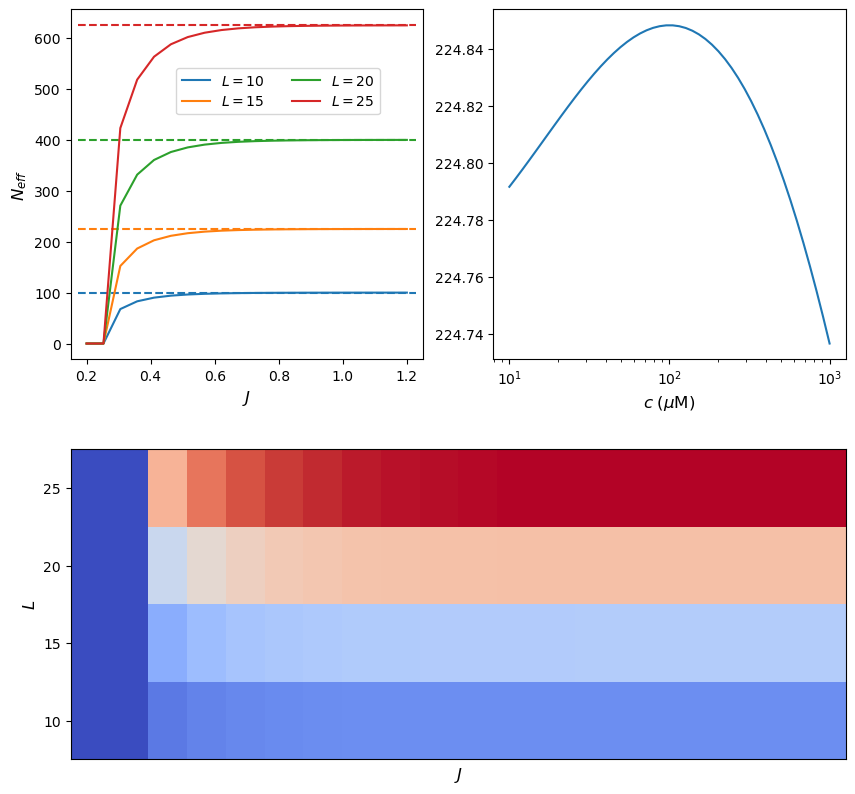

In [110]:
# theoretical result for Neff given Rsim
def N_eff(R,c,c0=100,Ki=18,Ka=2900):
    base = ((1+c/Ki)/(1+c/Ka))*((1+c0/Ka)/(1+c0/Ki))
    return np.log(R)/np.log(base)

# prepare figure
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

##############
## 3D plots ##
##############

ax1 = fig.add_subplot(gs[0,0])

ax2 = fig.add_subplot(gs[0,1])

ax3 = fig.add_subplot(gs[1,:])

# extract mean-field ratios
L_arr = np.array([10,15,20,25])
J_arr = np.linspace(0.2,1.2,20)
R_arr = np.zeros((L_arr.size,J_arr.size),dtype='float64')
c = 110

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        R_arr[l,j] = ratio_mfa(J,c,L**2)
    ax1.plot(J_arr,N_eff(R_arr[l,:],c),'-',color=colormap_aux(l),label=f'$L={L}$')
    ax1.axhline(y=L**2,xmin=0.02,xmax=0.98,ls='--',color=colormap_aux(l))
    
ax1.set_ylabel(r'$N_{eff}$',size=12)
ax1.set_xlabel(r'$J$',size=12)
ax1.legend(fontsize=10,ncol=2,loc=(0.3,0.7))

ax3.imshow(N_eff(R_arr,c),cmap=plt.cm.coolwarm,aspect=2)
#ax3.set_xticks(range(len(J_arr)), np.round(J_arr,2))
ax3.set_xticks([])
ax3.set_yticks(range(len(L_arr)), L_arr)
ax3.invert_yaxis()
ax3.set_xlabel(f'$J$',size=12)
ax3.set_ylabel(f'$L$',size=12)

# check that this method depends on the concentration
J = 1
L = 15
c_arr = np.logspace(1,3,50)
check_Neff = np.zeros_like(c_arr)
for k,c in enumerate(c_arr):
    R = ratio_mfa(J,c,L**2)
    check_Neff[k] = N_eff(R,c)
    
ax2.semilogx(c_arr,check_Neff)
ax2.set_xlabel(r'$c \; (\mu$M)',size=12)
plt.show()

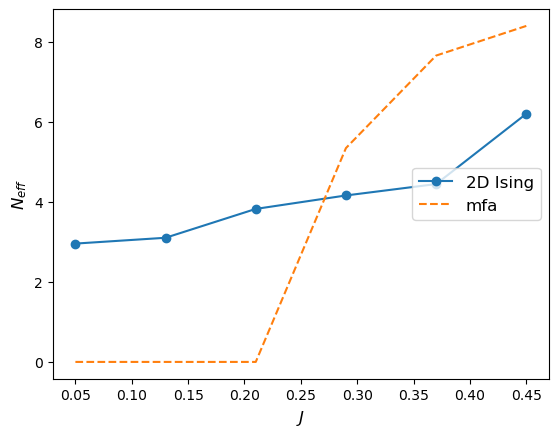

In [121]:
# parameters
n_samples = 5000
tf = 3000
L = 3
c = 110
J_arr = np.linspace(0.05,0.45,6)
R_sim_arr = np.zeros_like(J_arr)
R_mfa_arr = np.zeros_like(R_sim_arr)

# increase J systematically
for j,J in enumerate(J_arr):
    # extract an ensemble of states
    all_states,_,_ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c)

    # consider only the last time step of each realisation
    last_act = 0.5 + 0.5*np.mean(all_states[:,-1,:,:],axis=(1,2))

    # estimate the ratio
    R_sim_arr[j] = np.sum(last_act < 0.5)/np.sum(last_act > 0.5)
    R_mfa_arr[j] = ratio_mfa(J,c,L**2)
    
plt.plot(J_arr,N_eff(R_sim_arr,c),'-o',label='2D Ising')
plt.plot(J_arr,N_eff(R_mfa_arr,c),'--',label='mfa')
plt.xlabel(r'$J$',size=12)
plt.ylabel(r'$N_{eff}$',size=12)
plt.legend(fontsize=12,loc='center right')
plt.show()

## Dose-response curve (Ising)

In [6]:
@numba.jit(nopython=True)
def dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr,periodic_boundary=False):
    # set when the concentration is changed
    step_change = 1000

    # store results
    all_responses = np.zeros((J_arr.size,cnew_arr.size,L_arr.size),dtype='float32')
    all_var = np.zeros_like(all_responses,dtype='float32')

    # perform simulation for various L, J and cnew
    for k,L in enumerate(L_arr):
        # update number of samples
        n_samples_L = n_samples//L
        #loop through various coupling strengths
        for i,J in enumerate(J_arr):
            # loop for various new concentrations
            for j, c_new in enumerate(cnew_arr):
                # obtain results
                all_states, ensemble_av, _ = ensemble_averaged_ising(n_samples_L,n_steps,tf,L,J,
                                                                     step_change=step_change,cnew=c_new,
                                                                     periodic_boundary=periodic_boundary)
                
                # extract ensemble variance on the activity; note the prefactor!
                ensemble_var = np.zeros((n_steps,L,L),dtype='float32')
                for step in range(n_steps):
                    for spin1 in range(L):
                        for spin2 in range(L):
                            ensemble_var[step,spin1,spin2] = 0.25*np.var(all_states[:,step,spin1,spin2])

                # extract activity, weird numba way
                av_spin = np.sum(np.sum(ensemble_av,axis=-1),axis=-1)/L**2
                activity = 0.5*(av_spin + 1)

                # set baseline and extract new equilibrium
                baseline = np.mean(activity[500:step_change-1]) # remove transient
                new_act = np.mean(activity[-1000:])
                
                # save response
                all_responses[i,j,k] = new_act - baseline
                
                # calculate error in the response, assuming a_pre and a_post have uncorrelated errors
                ens_var_baseline = np.mean(ensemble_var[500:step_change-1])/ensemble_var[500:step_change-1].size
                ens_var_new = np.mean(ensemble_var[-1000:])/ensemble_var[-1000:].size
                
                var_baseline = np.var(activity[500:step_change-1])
                var_new = np.var(activity[-1000:])
                
                # save errors
                all_var[i,j,k] = ens_var_baseline + ens_var_new + var_baseline + var_new

        print('Done for L = ', L)
            
    return all_responses, all_var

# define Hill function
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5)

# function to compute theoretical drc based on MWC model
def theoretical_drc(cnew_arr,N,ampl):
    # fix some parameters
    c0 = 100
    delta_f = -2
    Ki = 18
    Ka = 2900
    
    # adequately set initial methylation
    mbase = N/2.
    m0 = mbase - (N/delta_f)*np.log((1+100/18)/(1+100/2900))
    
    # calculate free-energy difference
    f0 = N*np.log((1 + c0/Ki)/(1 + c0/Ka)) + delta_f*(m0 - mbase)
    fc = N*np.log((1 + cnew_arr/Ki)/(1 + cnew_arr/Ka)) + delta_f*(m0 - mbase)
    
    # calculate average activities
    a_pre = 1/(1 + np.exp(f0))
    a_post = 1/(1 + np.exp(fc))
    
    # return response
    return ampl*(a_post-a_pre)

In [50]:
# make a meshgrid for plotting
J_arr = np.linspace(0,0.45,7)
cnew_arr = np.logspace(-0.5,4.5,25)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 2*10**3
n_steps = 4000
tf = 2*10**3
L_arr = np.array([2,4,8])

# extract dose-response curves
all_responses, all_var = dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr)

Done for L =  2
Done for L =  4
Done for L =  8


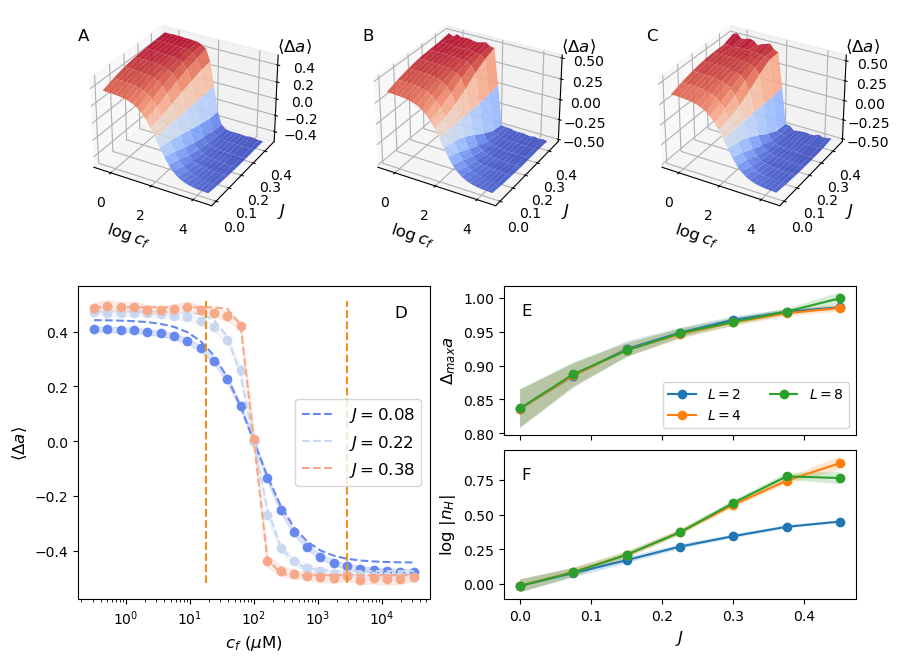

In [51]:
# preparation
fig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(6, 6)

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

##############
## 3D plots ##
##############

ax1 = fig.add_subplot(gs[:2,:2], projection='3d')

ax2 = fig.add_subplot(gs[:2,2:4], projection='3d')

ax3 = fig.add_subplot(gs[:2,4:], projection='3d')

text_list = ['A','B','C']
for k,ax in enumerate((ax1,ax2,ax3)):
    ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses[:,:,k],cmap=plt.cm.coolwarm,alpha=0.9)
    ax.set_xlabel(r'$\log c_f$',size=12)
    ax.set_ylabel('$J$',size=12)
    ax.text2D(0.95,0.8,r'$\langle \Delta a \rangle$',size=12,transform = ax.transAxes)
    ax.text2D(0,0.85,text_list[k],size=12,transform = ax.transAxes)

#################
## Projections ##
#################

ax4 = fig.add_subplot(gs[2:4,:3])

# perform fitting
parm_arr = np.zeros((2,J_arr.size,L_arr.size))
var_arr = np.zeros_like(parm_arr)

for k in range(L_arr.size):
    for j in range(J_arr.size):
        popt, pcov = curve_fit(hill_func_max,cnew_arr,all_responses[j,:,k],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,k]))
        parm_arr[:,j,k] = popt
        var_arr[:,j,k] = [pcov[l,l] for l in range(2)]

        # visual inspection for some results
        if (j+1) % 2 == 0 and k == 1:
            # set color
            color = colormap(j/J_arr.size)
            
            # plots
            ax4.semilogx(cnew_arr,all_responses[j,:,k],'o',color=color)
            ax4.fill_between(cnew_arr,all_responses[j,:,k]-np.sqrt(all_var[j,:,k]),
                             all_responses[j,:,k]+np.sqrt(all_var[j,:,k]),color=color,alpha=0.2)
            ax4.semilogx(cnew_arr,hill_func_max(cnew_arr,*popt),'--',
                         color=color,label=f'$J={np.round(J_arr[j],2)}$')

# figure formatting
ax4.axvline(x=18,ymin=0.05,ymax=0.95,linestyle='--',color=my_yellow)
ax4.axvline(x=2900,ymin=0.05,ymax=0.95,linestyle='--',color=my_yellow)
ax4.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax4.set_ylabel(r'$\langle \Delta a \rangle$',size=12)
ax4.legend(fontsize=12)
ax4.text(0.9,0.9,'D',size=12,transform = ax4.transAxes)

#####################
## Hill parameters ##
#####################

ax5 = fig.add_subplot(gs[2,3:])
ax6 = fig.add_subplot(gs[3,3:],sharex=ax5)

# transform errors on absolute Hill coefficient (propagation of errors)
var_hill = var_arr[1,:,:]
var_loghill = var_hill/(np.log(10)*parm_arr[1,:,:])**2

# mark measurement errors
mask = var_loghill > 1
var_loghill[mask] = 0 

# show fitting parameters for various L
for k in range(L_arr.size):
    ax5.plot(J_arr,-1*parm_arr[0,:,k],'-o',label=f'$L={L_arr[k]}$')
    ax5.fill_between(J_arr,-1*parm_arr[0,:,k]+np.sqrt(var_arr[0,:,k]),
                     -1*parm_arr[0,:,k]-np.sqrt(var_arr[0,:,k]),alpha=0.2)
    ax6.plot(J_arr,np.log10(np.abs(parm_arr[1,:,k])),'-o',label=f'$L={L_arr[k]}$')
    ax6.fill_between(J_arr,np.log10(np.abs(parm_arr[1,:,k]))-np.sqrt(var_loghill[:,k]),
                     np.log10(np.abs(parm_arr[1,:,k]))+np.sqrt(var_loghill[:,k]),alpha=0.2)

# formatting
ax5.set_ylabel(r'$\Delta_{max} a$',size=12)
ax5.text(0.05,0.8,'E',size=12,transform = ax5.transAxes)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.legend(fontsize=10,ncol=2,loc='lower right')

ax6.set_ylabel(r'log $|n_H|$',size=12)
ax6.set_xlabel('$J$',size=12)
ax6.text(0.05,0.8,'F',size=12,transform = ax6.transAxes)

plt.tight_layout()
plt.subplots_adjust(wspace=1.1, hspace=0.1)

plt.show()

## Estimating $N_\text{eff}$

In [148]:
# parameters
n_samples = 500
n_steps = 4000
tf = 1500
J_arr = np.linspace(0.01,0.35,6)
L_arr = np.arange(2,16,1)

# make a meshgrid for plotting
cnew_arr = np.logspace(0.,4.,25)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# extract dose-response curves
all_responses, all_var = dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr,periodic_boundary=False)

Done for L =  2
Done for L =  3
Done for L =  4
Done for L =  5
Done for L =  6
Done for L =  7
Done for L =  8
Done for L =  9
Done for L =  10
Done for L =  11
Done for L =  12
Done for L =  13
Done for L =  14
Done for L =  15


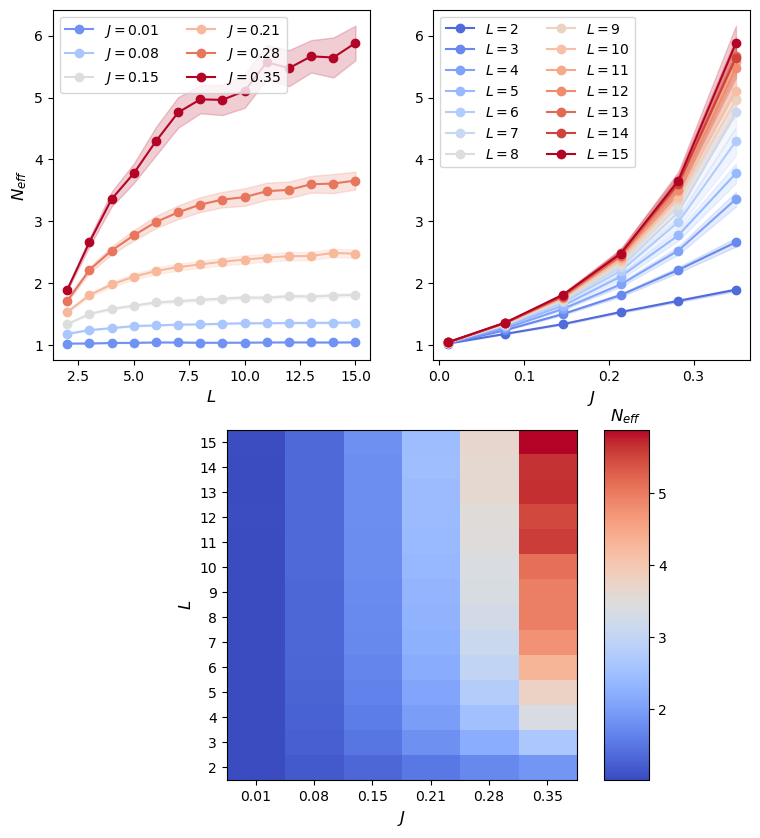

In [151]:
# array to store results
parm_hm_arr = np.zeros((2,J_arr.size,L_arr.size),dtype='float32')
var_hm_arr = np.zeros_like(parm_hm_arr)

# extract Neff for various L and J
for j,J in enumerate(J_arr):
    for l,L in enumerate(L_arr):
        # perform fitting
        popt, pcov = curve_fit(theoretical_drc,cnew_arr,all_responses[j,:,l],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,l]))
        
        # store results
        parm_hm_arr[:,j,l] = popt
        var_hm_arr[:,j,l] = [pcov[i,i] for i in range(2)]
        
# preparation
fig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])


for j, J in enumerate(J_arr):
    color = colormap((j+0.99)/J_arr.size)
    ax1.plot(L_arr,parm_hm_arr[0,j,:],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax1.fill_between(L_arr,parm_hm_arr[0,j,:]-np.sqrt(var_hm_arr[0,j,:]),
                     parm_hm_arr[0,j,:]+np.sqrt(var_hm_arr[0,j,:]),color=color,alpha=0.2)

#plt.plot(L_arr,L_arr**2,ls='--',label=r'$J\to \infty$')
ax1.set_xlabel(r'$L$',size=12)
ax1.set_ylabel(r'$N_{eff}$',size=12)
ax1.legend(fontsize=10,ncol=2)

for l, L in enumerate(L_arr):
    color = colormap((l+0.99)/L_arr.size)
    ax2.plot(J_arr,parm_hm_arr[0,:,l],'-o',color=color,label=f'$L={L}$')
    ax2.fill_between(J_arr,parm_hm_arr[0,:,l]-np.sqrt(var_hm_arr[0,:,l]),
                     parm_hm_arr[0,:,l]+np.sqrt(var_hm_arr[0,:,l]),color=color,alpha=0.2)

#plt.plot(L_arr,L_arr**2,ls='--',label=r'$J\to \infty$')
ax2.set_xlabel(r'$J$',size=12)
ax2.legend(fontsize=10,ncol=2)

im = ax3.imshow(parm_hm_arr[0,:,:].T,cmap=plt.cm.coolwarm,aspect=J_arr.size/L_arr.size)
ax3.set_xticks(range(len(J_arr)), np.round(J_arr,2))
ax3.set_yticks(range(len(L_arr)), L_arr)
ax3.invert_yaxis()
ax3.set_xlabel(f'$J$',size=12)
ax3.set_ylabel(f'$L$',size=12)

# formatting the colorbar
cax = fig.add_axes([ax3.get_position().x1+0.03,ax3.get_position().y0,0.05,ax3.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title(r'$N_{eff}$',size=12)

plt.show()

Expected N for a gain of G=1.73: 8.968433486442425


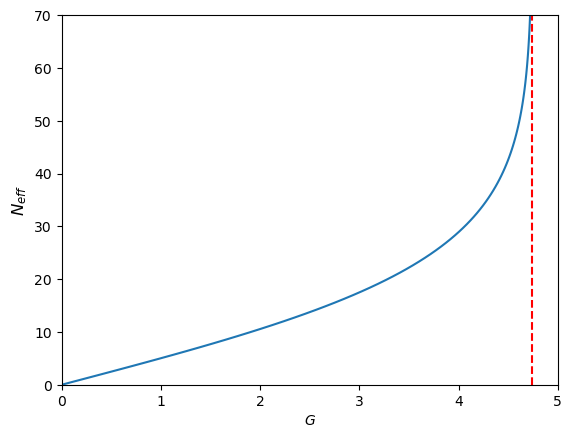

In [23]:
def Neff_eq(Neff,G,c0=100,cf=90,Ki=18,Ka=2900):
    # define epsilon0 as per usual
    epsilon0 = -Neff*np.log((1+c0/Ki)/(1+c0/Ka))
    
    # define free-energy differences
    F = epsilon0 + Neff*np.log((1+cf/Ki)/(1+cf/Ka))
    
    # activity change
    Delta_a = 1/(1+np.exp(F)) - 0.5
    
    # return equation for the gain G
    return G-Delta_a/np.log(c0/cf)

# show what you would expect based on Mattingly's data
G = 1.73
root = fsolve(Neff_eq,[1],args=(G))
print('Expected N for a gain of G=1.73:', root[0])

# solve the equation for Neff
G_plt = np.linspace(0,5,100)
N_plt = np.linspace(0,70,100)
N_plt, G_plt = np.meshgrid(N_plt, G_plt)
eq = Neff_eq(N_plt,G_plt)

plt.contour(G_plt,N_plt, eq, levels=[0],cmap='tab10')
plt.axvline(x=0.5/np.log(100/90),ymin=0.,ymax=1,ls='--',color='r')
plt.ylabel(r'$N_{eff}$',size=12)
plt.xlabel(r'$G$')
plt.show()

In [7]:
# Numba-compatible function for finding the indices of distinct values; similar to np.unique
@numba.jit(nopython=True)
def indices_distinct_vals(arr):
    # sort the array and extract index when each distinct value occurs for the first time
    indices = np.searchsorted(np.sort(arr), np.unique(arr))
    
    # remove the first zero and add the final index manually
    return np.unique(arr), np.append(indices[1:],arr.size-1)

# function to calculate the cross-correlation for an ensemble of lattices
@numba.jit(nopython=True)
def cross_correlation(ensemble,L):
    # set up arrays
    r_arr = np.zeros((L**2)*(L**2 - 1)//2,dtype='float64')
    cc = np.zeros_like(r_arr)
    counter = 0
    
    # find the cross-correlation between a spin and every other spin
    for spin1 in range(L**2):
        # determine coordinates of spin1
        m1,n1 = np.divmod(spin1,L)
        
        # only consider the spins that have not been considered
        for spin2 in range(spin1+1,L**2):
            # determine position of spin2
            m2,n2 = np.divmod(spin2,L)
            
            # compute distance and cross-correlation, and update counter
            r_arr[counter] = np.sqrt((m2-m1)**2 + (n2-n1)**2)
            cc[counter] = np.corrcoef(np.vstack((ensemble[:,-1,m1,n1],ensemble[:,-1,m2,n2])))[0,1]
            counter += 1
            
    ######################
    ## Radial averaging ##
    ######################
    
    # extract distinct distances and their indices
    r_uniq, indices_uniq = indices_distinct_vals(r_arr) # determine the distinct values in r_arr
    
    # sort the cross-correlations based on r
    indices_sort = np.argsort(r_arr)
    sorted_cc = cc[indices_sort]
    
    # arrays to store sample statistics
    mean_cc = np.zeros_like(r_uniq,dtype='float64')
    std_cc = np.zeros_like(mean_cc)
    
    # prepare looping through unique indices
    idx1 = 0
    
    # actual averaging per distinct values
    for i,idx in enumerate(indices_uniq):
        mean_cc[i] = np.mean(sorted_cc[idx1:idx])
        std_cc[i] = np.std(sorted_cc[idx1:idx])
        idx1 = idx
    
    # ensure that only reasonable correlation lengths are considered
    cut_off = L//2
    r_mask = r_uniq <= cut_off
    
    # return the distances, cross-correlation and its standard deviation
    return r_uniq[r_mask], mean_cc[r_mask], std_cc[r_mask]

# exponential fit for extracting the correlation length
def exp_fit(r,xi):
    return np.exp(-r/xi)

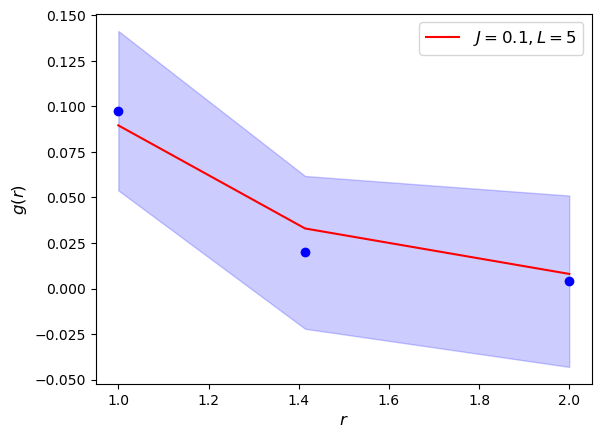

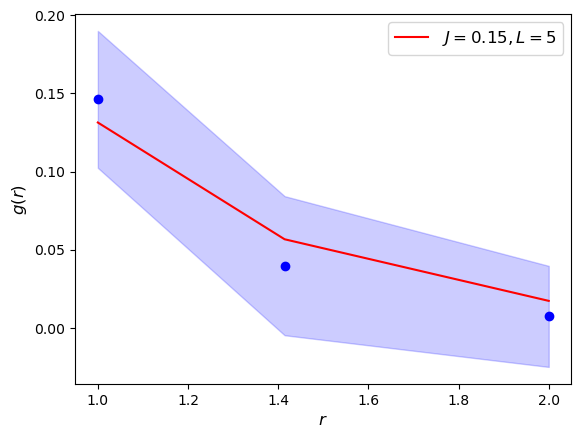

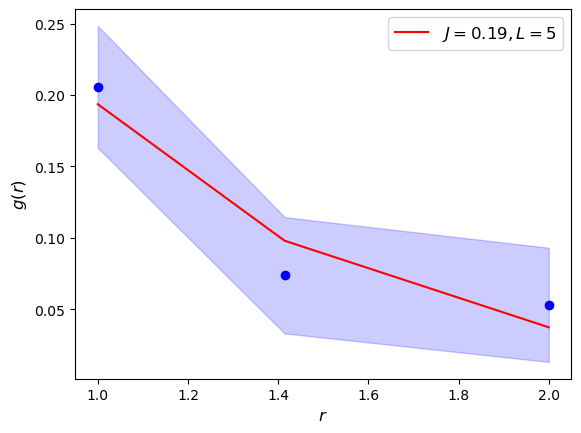

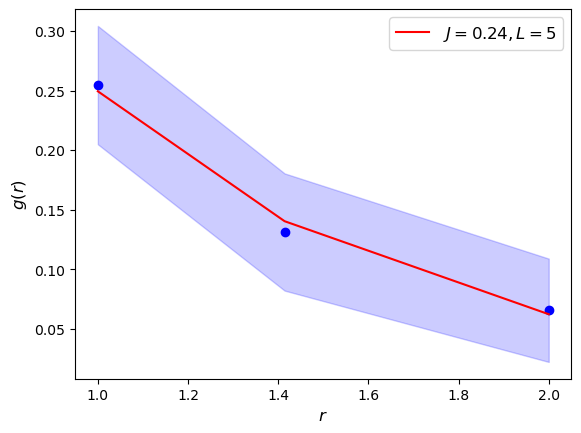

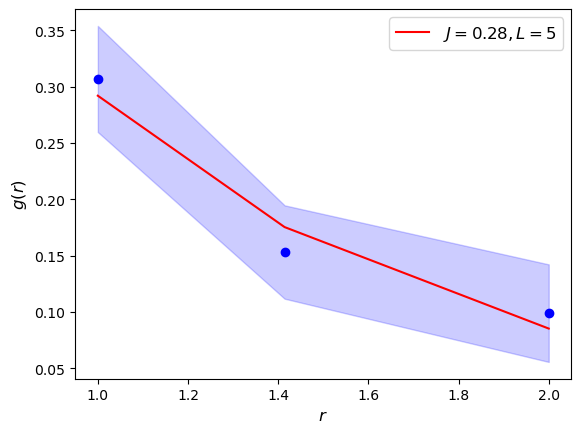

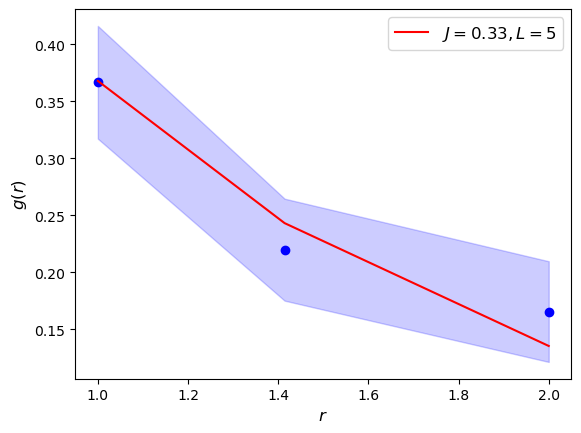

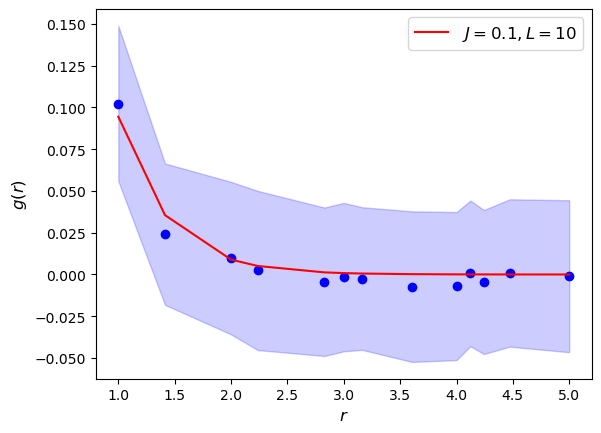

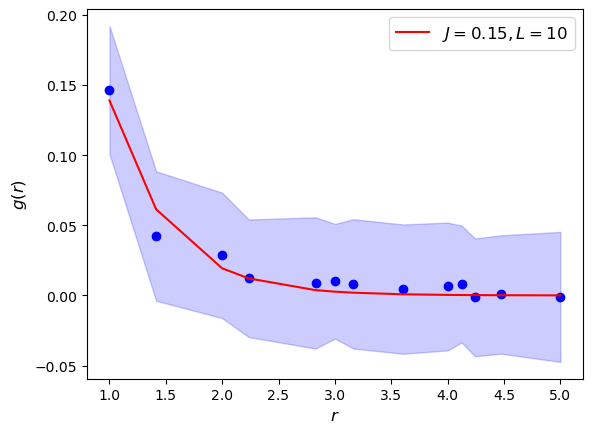

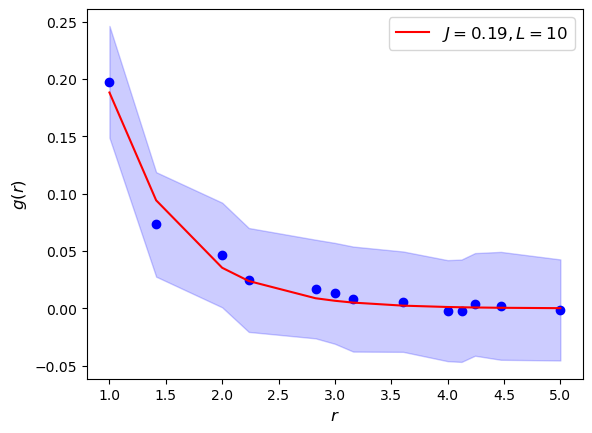

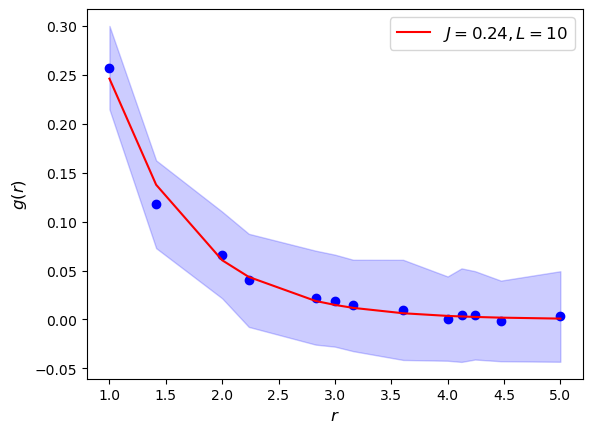

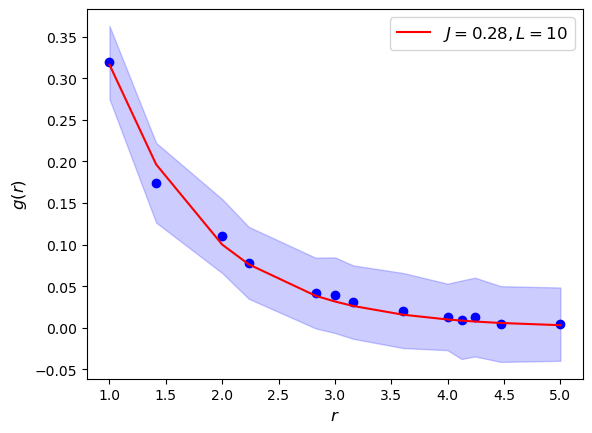

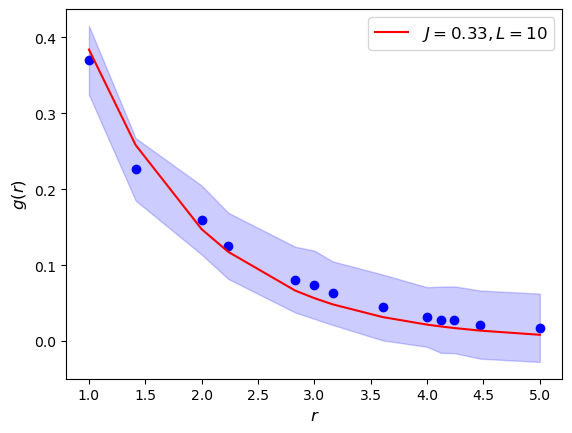

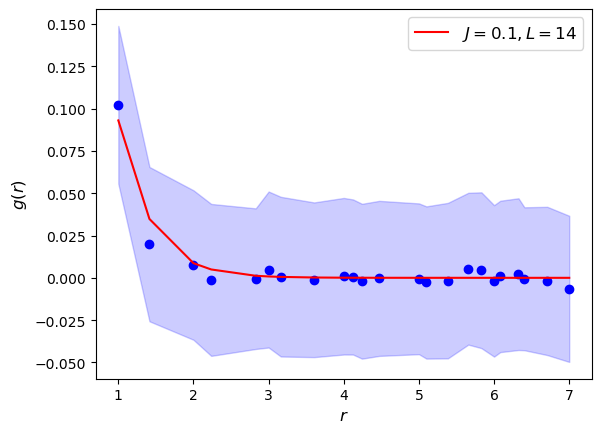

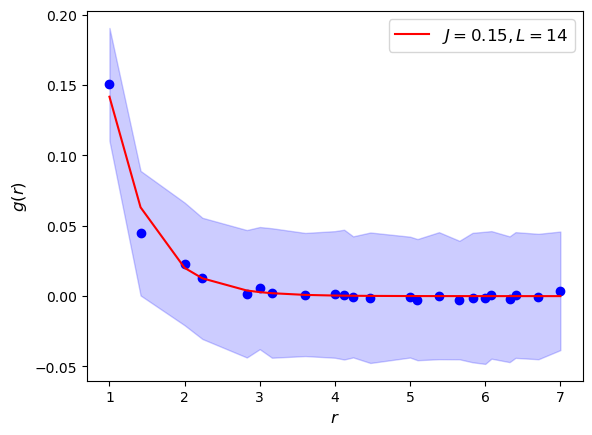

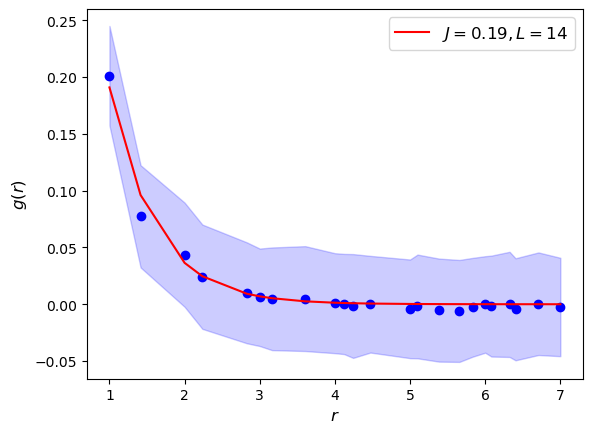

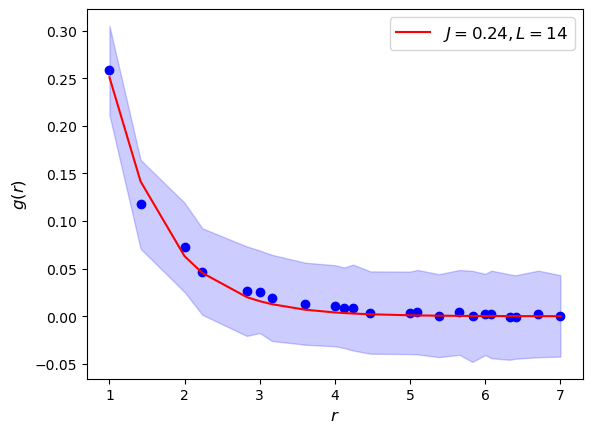

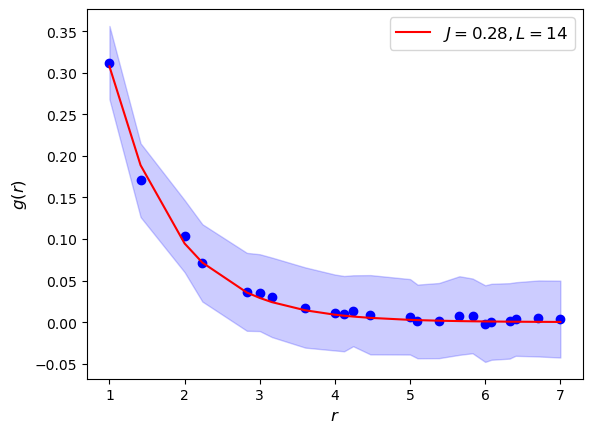

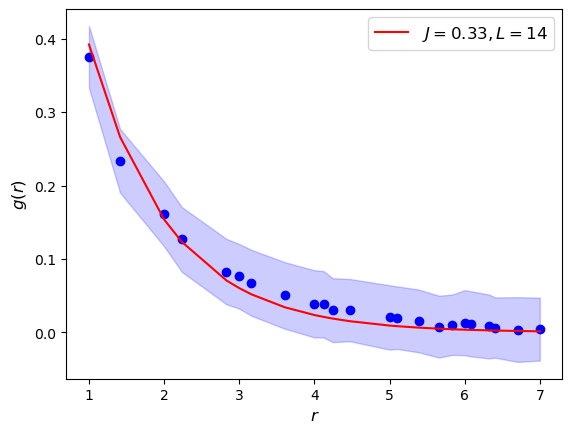

In [137]:
# set up parameters
c = 110
n_samples = 500
n_steps = 1000
tf = 750

J_arr = np.linspace(0.1,0.33,6)
L_arr = np.array([5,10,14])

all_xi = np.zeros((L_arr.size,J_arr.size),dtype='float64')
all_var_xi = np.zeros_like(all_xi)
Neff_sim_arr = np.zeros_like(all_xi)
Neff_mfa_arr = np.zeros_like(all_xi)

# consider various lattice size
for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # obtain an ensemble of Ising lattices
        ensemble,_,_ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,periodic_boundary=False)
        
        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(ensemble[:,-1,:,:],axis=(1,2))

        # estimate Neff both for the full and mfa Ising model
        R_sim = np.sum(last_act < 0.5)/np.sum(last_act > 0.5)
        Neff_sim_arr[l,j] = N_eff(R_sim,c)
        Neff_mfa_arr[l,j] = N_eff(ratio_mfa(J,c,L**2),c)

        # extract cross-correlation
        r_arr,mean_cc,std_cc = cross_correlation(ensemble,L)

        # extract correlation length and error bar
        popt,pcov = curve_fit(exp_fit,r_arr,mean_cc,sigma=std_cc,bounds=([0.],[np.inf]))
        all_xi[l,j] = popt[0]
        all_var_xi[l,j] = pcov[0,0]

        # show results
        plt.scatter(r_arr,mean_cc,color='b')
        plt.fill_between(r_arr,mean_cc-std_cc,mean_cc+std_cc,color='b',alpha=0.2)
        plt.plot(r_arr,exp_fit(r_arr,*popt),color='r',label=f'$J = {np.round(J,2)}, L = {L}$')
        plt.xlabel(r'$r$',size=12)
        plt.ylabel(r'$g(r)$',size=12)
        plt.legend(fontsize=12)
        plt.show()

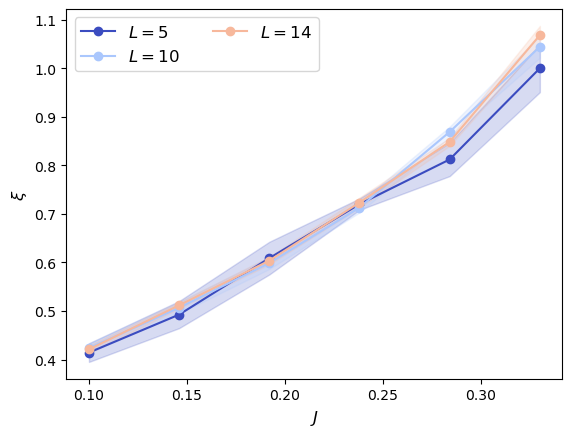

In [138]:
for l,L in enumerate(L_arr):
    # set color
    color = colormap(l/L_arr.size)
    # show correlation length for various J
    plt.plot(J_arr,all_xi[l,:],'-o',label=f'$L = {L}$',color=color)
    plt.fill_between(J_arr,all_xi[l,:]-np.sqrt(all_var_xi[l,:]),
                      all_xi[l,:]+np.sqrt(all_var_xi[l,:]),color=color,alpha=0.2)
plt.xlabel(r'$J$',size=12)
plt.ylabel(r'$\xi$',size=12)
plt.legend(fontsize=12,ncol=2)
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

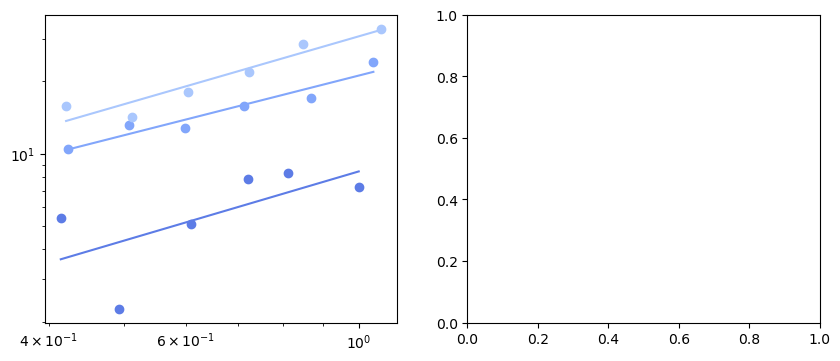

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

# extract slope for various L and J
def lin_fit(data,a,b):
    return a*data + b

all_gamma_sim = np.zeros(L_arr.size,dtype='float32')
all_gamma_sim_var = np.zeros_like(all_gamma_sim)
all_gamma_mfa = np.zeros(L_arr.size,dtype='float32')
all_gamma_mfa_var = np.zeros_like(all_gamma_mfa)

# show Neff and xi in a parametric plot
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax1.loglog(all_xi[l,:],Neff_sim_arr[l,:],'o',color=color,label=f'$L={L}$')
#    ax1.loglog(all_xi[l,:],Neff_mfa_arr[l,:],'o',color=color,label=f'$L={L}$')
    
    # perform fits
    # full Ising model
    slope_parms,pcov = curve_fit(lin_fit,np.log(all_xi[l,:]),np.log(Neff_sim_arr[l,:]))
    all_gamma_sim[l] = slope_parms[0]
    all_gamma_sim_var[l] = pcov[0,0]
    
    ax1.loglog(all_xi[l,:],np.exp(slope_parms[1])*(all_xi[l,:]**slope_parms[0]),color=color)
    
    # mfa
#     slope_parms,pcov = curve_fit(lin_fit,np.log(all_xi[l,:]),np.log(Neff_mfa_arr[l,:]))
#     all_gamma_mfa[l] = slope_parms[0]
#     all_gamma_mfa_var[l] = pcov[0,0]
    
#     ax1.loglog(all_xi[l,:],np.exp(slope_parms[1])*(all_xi[l,:]**slope_parms[0]),color=color)

ax1.legend(fontsize=12,ncol=2)
ax1.set_xlabel(r'$\xi$',size=12)
ax1.set_ylabel(r'$N_{eff}$',size=12)

ax2.plot(L_arr,all_gamma_sim,'-o')
ax2.fill_between(L_arr,all_gamma_sim-np.sqrt(all_gamma_sim_var),all_gamma_sim+np.sqrt(all_gamma_sim_var),alpha=0.2)

# ax2.plot(L_arr,all_gamma_mfa,'-x')
# ax2.fill_between(L_arr,all_gamma_mfa-np.sqrt(all_gamma_mfa_var),all_gamma_mfa+np.sqrt(all_gamma_mfa_var),alpha=0.2)

ax2.set_xlabel(r'$L$',size=12)
ax2.set_ylabel(r'Exponent $\gamma$',size=12)


plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

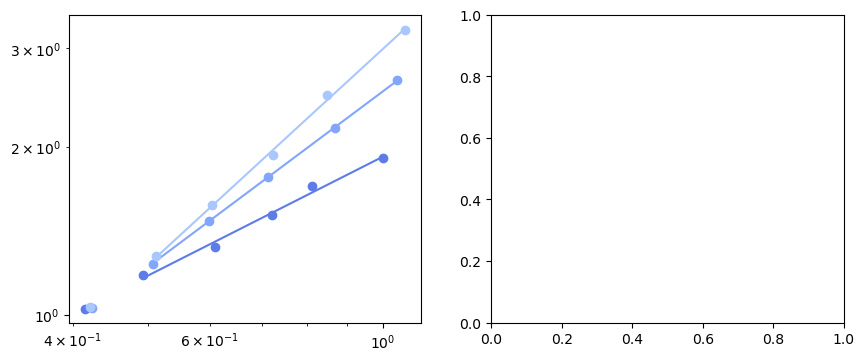

In [146]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

# extract slope for various L and J
def lin_fit(data,a,b):
    return a*data + b

all_gamma = np.zeros(L_arr.size,dtype='float32')
all_gamma_var = np.zeros_like(all_gamma)

# show Neff and xi in a parametric plot
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax1.loglog(all_xi[l,:],parm_hm_arr[0,:,l],'o',color=color,label=f'$L={L}$')
    
    # perform fit
    slope_parms,pcov = curve_fit(lin_fit,np.log(all_xi[l,1:]),np.log(parm_hm_arr[0,1:,l]))
    all_gamma[l] = slope_parms[0]
    all_gamma_var[l] = pcov[0,0]
    
    # show the fit
    ax1.loglog(all_xi[l,1:],np.exp(slope_parms[1])*(all_xi[l,1:]**slope_parms[0]),color=color)

ax1.legend(fontsize=12,ncol=2)
ax1.set_xlabel(r'$\xi$',size=12)
ax1.set_ylabel(r'$N_{eff}$',size=12)

ax2.plot(L_arr,all_gamma,'-o')
ax2.fill_between(L_arr,all_gamma-np.sqrt(all_gamma_var),all_gamma+np.sqrt(all_gamma_var),alpha=0.2)

ax2.set_xlabel(r'$L$',size=12)
ax2.set_ylabel(r'Exponent $\gamma$',size=12)


plt.show()

## Comparison of dynamics

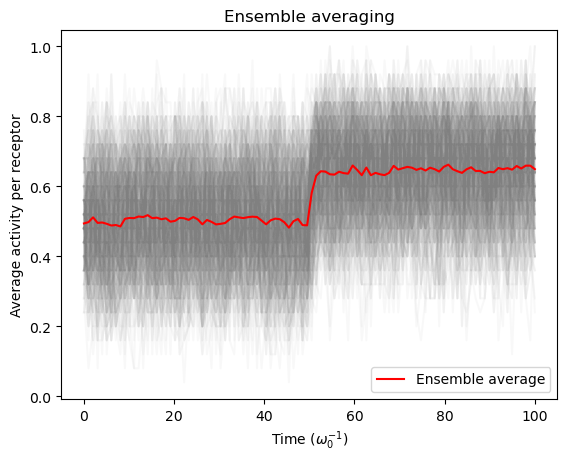

In [9]:
# define nonadaptive noise kernel
def Kstar(time,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# parameters
n_samples = 250
n_steps = 10**2
tf = 100
c = 100
cnew = 70
step_change = 50
L = 5
J = 0.2

# obtain results
all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,cnew=cnew,
                                                          step_change=step_change,periodic_boundary=False)

# convert to activity 
av_act = 0.5*(ensemble_av + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(av_act,axis=(1,2)),color='red',label='Ensemble average')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title('Ensemble averaging')
plt.legend()
plt.show()

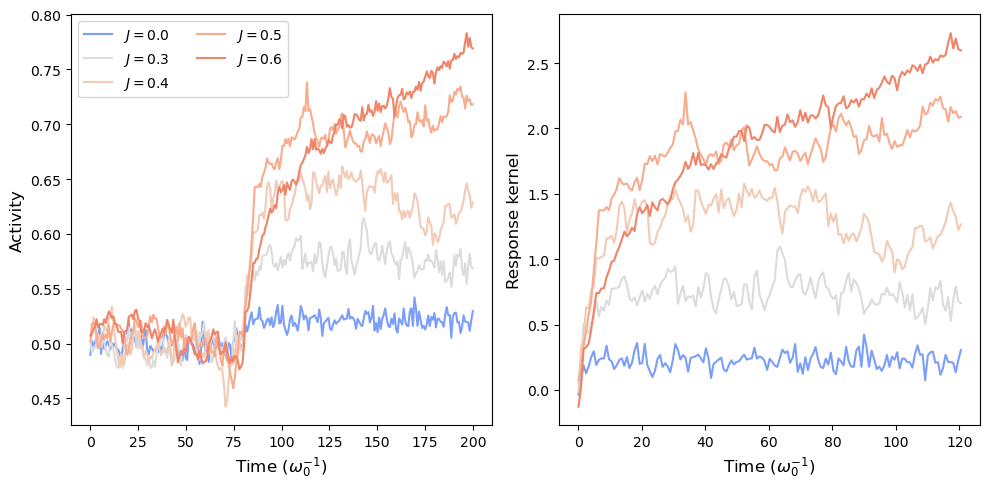

In [10]:
# function for finding response from a given ensemble
def response_finder(all_states,step_change,time,cnew,c=100,co=1000):
    # extract mean as a function of time
    activity = 0.5*(np.mean(all_states,axis=(0,2,3)) + 1)
    
    # find response and shift time
    baseline = np.mean(activity[step_change-co:step_change])
    response = (activity[step_change-1:] - baseline)/np.log(c/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sds = np.std(0.5*all_states[:,step_change-1:,:,:],axis=(0,2,3))/np.log(c/cnew)
    
    return response, sds, shifted_time

# parameters
n_samples = 250
n_steps = 250
tf = 200
c = 100
cnew = 90
step_change = 100
co = 50
L = 5

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

for J in [0.,0.3,0.4,0.5,0.6]:
    # obtain results
    all_states, ensemble_av, time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,cnew=cnew,
                                                          step_change=step_change,periodic_boundary=False)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av + 1)

    ax1.plot(time,np.mean(ensemble_av_act,axis=(1,2)),label=f'$J={J}$',color=colormap(J+0.2))
    
    # extract response
    response, sds, shifted_time = response_finder(all_states,step_change,time,cnew,c=c,co=co)
    ax2.plot(shifted_time,response,color=colormap(J+0.2))

ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.legend(fontsize=10,ncol=2)

ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_ylabel('Response kernel',size=12)

plt.tight_layout()
plt.show()

# # obtain response for various L
# J = 0.1

# for L in [5,10,20]:
#     # obtain results
#     all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,cnew=cnew,
#                                                           step_change=step_change,periodic_boundary=False)
#     # convert to activity 
#     ensemble_av_act = 0.5*(ensemble_av + 1)

#     plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'L ={L}')

# plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
# plt.ylabel('Average activity per receptor',size=12)
# plt.title(f'Average response for various $L$ ($J={J}$)')
# plt.legend(fontsize=12)
# plt.show()

Done for L =  2
Done for L =  4
Done for L =  6
Done for L =  8
Done for L =  10


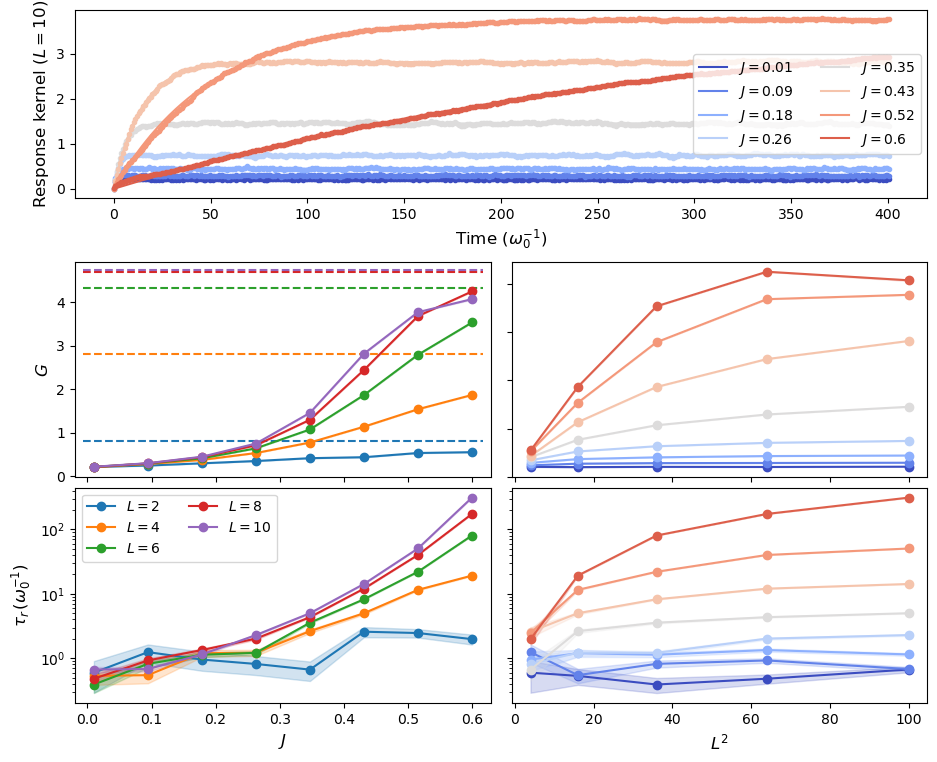

In [20]:
# define nonadaptive noise kernel
def Kstar(time,G,tau_r):
    return G*(1-np.exp(-time/tau_r))

# drc for MWC model
@numba.jit(nopython=True)
def theoretical_drc_MWC(cnew_arr,
                    N=6,c0=100,delta_f=-2,Ki=18,Ka=2900):
    # calculate free-energy difference
    m0=0.5*(N+N*np.log((1+100/18)/(1+100/2900)))
    mbase = N/2.
    f0 = N*np.log((1 + c0/Ki)/(1 + c0/Ka)) + delta_f*(m0 - mbase)
    fc = N*np.log((1 + cnew_arr/Ki)/(1 + cnew_arr/Ka)) + delta_f*(m0 - mbase)
    
    # calculate average activities
    a_pre = 1/(1 + np.exp(f0))
    a_post = 1/(1 + np.exp(fc))
    
    # return response
    return a_post-a_pre

# quantify how the gain and response time depend on J
J_arr = np.linspace(0.01,0.6,8)
L_arr = np.array([2,4,6,8,10])
    
n_samples = 3000
n_steps = 1000
tf = 800
c = 100
cnew = 90
step_change = 500
co = 100

# auxiliary quantities
MWC_gain = theoretical_drc_MWC(cnew,N=L_arr**2)/np.log(c/cnew)

Kstar_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float32')
Kstar_sds = np.zeros_like(Kstar_parms)

fig = plt.figure(figsize=(11,9))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(bottom=0.42)
ax1 = fig.add_subplot(gs1[0,:])

gs2 = gridspec.GridSpec(2, 2)
gs2.update(top=0.6, hspace=0.05, wspace=0.05)

ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[0,1])
ax4 = fig.add_subplot(gs2[1,0],sharex = ax2)
ax5 = fig.add_subplot(gs2[1,1],sharex = ax3)

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # obtain results
        all_states, ensemble_av, time = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=c,cnew=cnew,
                                                              step_change=step_change,periodic_boundary=False)

        # extract response
        response, sds, shifted_time = response_finder(all_states,step_change,time,cnew,c=c,co=co)

        # fit
        popt, pcov = curve_fit(Kstar,shifted_time,response,p0=[1,1],sigma=sds)
        Kstar_parms[:,l,j] = popt
        Kstar_sds[:,l,j] = [np.sqrt(pcov[i,i]) for i in range(2)]

        # show response kernels only for one value of L
        if l == 4:
            ax1.plot(shifted_time,response,'.',color=colormap(j/J_arr.size))
            ax1.plot(shifted_time,Kstar(shifted_time,*popt),
                     color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
            
    # show how the gain and response time depend on J
    for i,ax in enumerate((ax2,ax4)):
        ax.plot(J_arr,Kstar_parms[i,l,:],'-o',color=colormap_aux(l),label=f'$L={L}$')
        ax.fill_between(J_arr,Kstar_parms[i,l,:]-Kstar_sds[i,l,:],Kstar_parms[i,l,:]+Kstar_sds[i,l,:],
                        alpha=0.2,color=colormap_aux(l))
        #ax.axvline(x=J_slice,ymin=0.02,ymax=0.98,ls='--',color='grey')
        
    ax2.axhline(y=MWC_gain[l],xmin=0.02,xmax=0.98,ls='--',color=colormap_aux(l))
    print('Done for L = ',L)
    
# show how the gain and response time depend on L at a specific J
for i,ax in enumerate((ax3,ax5)):
    for j,J in enumerate(J_arr):
        ax.plot(L_arr**2,Kstar_parms[i,:,j],'-o',color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
        ax.fill_between(L_arr**2,Kstar_parms[i,:,j]-Kstar_sds[i,:,j],Kstar_parms[i,:,j]+Kstar_sds[i,:,j],
                        alpha=0.2,color=colormap(j/J_arr.size))

# formatting
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel(f'Response kernel ($L={L_arr[4]}$)',size=12)
ax1.legend(loc='center right',ncol=2,fontsize=10)

ax2.set_ylabel(r'$G$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4.set_yscale('log')
ax4.set_ylabel(r'$\tau_r \, (\omega_0^{-1})$',size=12)
ax4.set_xlabel(r'$J$',size=12)
ax4.legend(ncol=2,fontsize=10)

ax5.set_xlabel(r'$L^2$',size=12)
ax5.set_yscale('log')
plt.setp(ax5.get_yticklabels(), visible=False)

plt.show()

In [8]:
# noise kernel prep

# function for averaging over two axes in numba
@numba.jit(nopython=True)
def lattice_mean(lattice):
    return np.sum(np.sum(lattice[:,:,:],axis=-1),axis=-1)/lattice[0,:,:].size

# function for finding several realisations of single-cell activity
@numba.jit(nopython=True)
def activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J):
    # array to save results
    all_act = np.zeros((n_steps,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        _, cell_av, time = ensemble_averaged_ising(Nc,n_steps,tf,L,J)
        
        # extract activity
        all_act[:,sample] = 0.5*(lattice_mean(cell_av) + 1)
        
    return all_act, time

# function to compute noise kernel
def autocorr(all_act,time,co):   
    # obtain average of product 
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

Parameters of best fit: [sigma_n, tau_n] = [0.0873595  0.65406586]


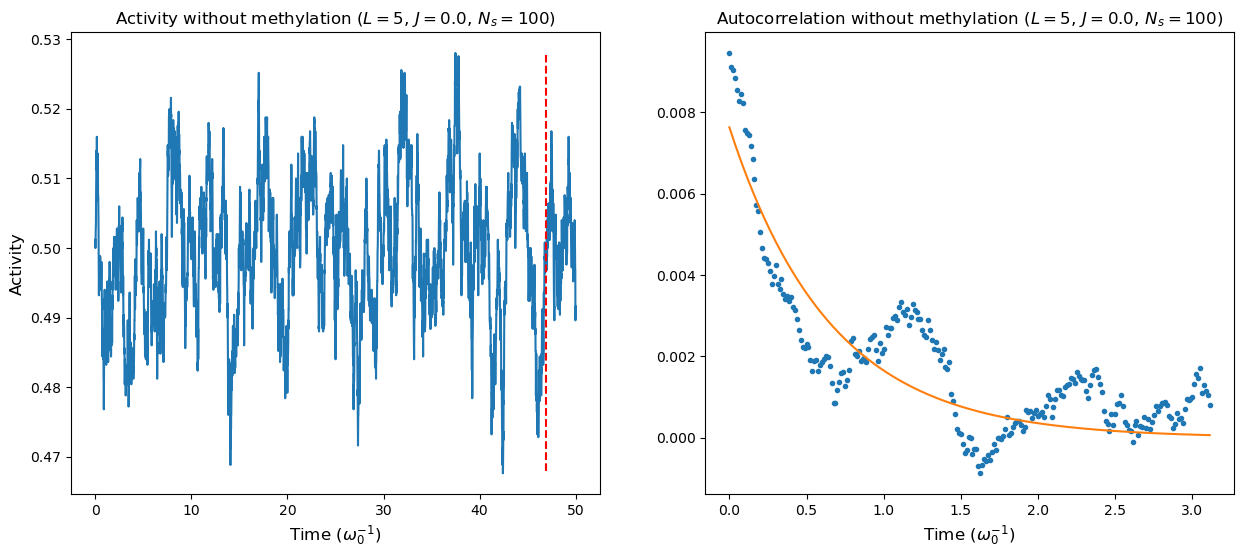

In [14]:
# time-related parameters
n_steps = 4000
tf = 50
co = 3750

# cluster-related parameters
n_samples = 100
Nc = 1
L = 5
J = 0.

# obtain activities
all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(time,np.mean(all_act,axis=1))
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Activity without methylation $(L={L},\, J={J},\, N_s={n_samples})$')
ax1.axvline(x=tf*co/n_steps,ymin=0.05,ymax=0.95,color='r',linestyle='--')

# fitting function
def noise_kernel(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

popt, pcov = curve_fit(noise_kernel,time_s,auto_corr)

# show the data with fit
print('Parameters of best fit: [sigma_n, tau_n] =', popt)

ax2.plot(time_s,auto_corr,'.')
ax2.plot(time_s,noise_kernel(time_s,*popt))
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Autocorrelation without methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

plt.show()

Done for L =  2
Done for L =  4
Done for L =  6
Done for L =  8
Done for L =  10


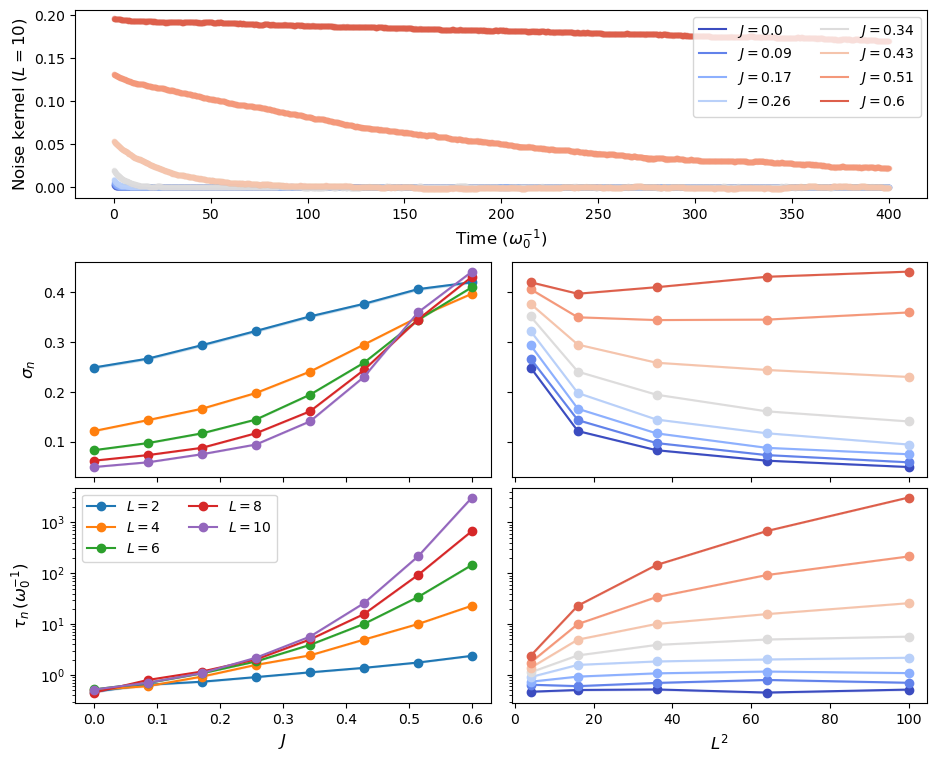

In [21]:
# quantify how the noise amplitidue and time depend on J
J_arr = np.linspace(0.0,0.6,8)
L_arr = np.array([2,4,6,8,10])
    
# time-related parameters
n_steps = 5000
tf = 500
co = 1000

# cluster-related parameters
n_samples = 3000
Nc = 1

# prep
noise_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float32')
noise_sds = np.zeros_like(noise_parms)

fig = plt.figure(figsize=(11,9))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(bottom=0.42)
ax1 = fig.add_subplot(gs1[0,:])

gs2 = gridspec.GridSpec(2, 2)
gs2.update(top=0.6, hspace=0.05, wspace=0.05)

ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[0,1])
ax4 = fig.add_subplot(gs2[1,0],sharex = ax2)
ax5 = fig.add_subplot(gs2[1,1],sharex = ax3)

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # obtain activities
        all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

        # obtain autocorrelation
        auto_corr, time_s = autocorr(all_act,time,co)

        # fitting
        popt, pcov = curve_fit(noise_kernel,time_s,auto_corr)
        noise_parms[:,l,j] = popt
        noise_sds[:,l,j] = [np.sqrt(pcov[i,i]) for i in range(2)]

        # show noise kernels only for one value of L
        if l == 4:
            ax1.plot(time_s,auto_corr,'.',color=colormap(j/J_arr.size),alpha=0.3)
            ax1.plot(time_s,noise_kernel(time_s,*popt),
                     color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
            
    # show how the noise amplitidue and time depend on J
    for i,ax in enumerate((ax2,ax4)):
        ax.plot(J_arr,noise_parms[i,l,:],'-o',color=colormap_aux(l),label=f'$L={L}$')
        ax.fill_between(J_arr,noise_parms[i,l,:]-noise_sds[i,l,:],noise_parms[i,l,:]+noise_sds[i,l,:],
                        alpha=0.2,color=colormap_aux(l))
        #ax.axvline(x=J_slice,ymin=0.02,ymax=0.98,ls='--',color='grey')
        
    print('Done for L = ',L)
    
# show how the noise amplitidue and time depend on L at a specific J
for i,ax in enumerate((ax3,ax5)):
    for j,J in enumerate(J_arr):
        ax.plot(L_arr**2,noise_parms[i,:,j],'-o',color=colormap(j/J_arr.size),label=f'$L={L}$')
        ax.fill_between(L_arr**2,noise_parms[i,:,j]-noise_sds[i,:,j],noise_parms[i,:,j]+noise_sds[i,:,j],
                        alpha=0.2,color=colormap(j/J_arr.size))

# formatting
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel(f'Noise kernel ($L={L_arr[4]}$)',size=12)
ax1.legend(loc='upper right',ncol=2,fontsize=10)

ax2.set_ylabel(r'$\sigma_n$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4.set_yscale('log')
ax4.set_ylabel(r'$\tau_n \, (\omega_0^{-1})$',size=12)
ax4.set_xlabel(r'$J$',size=12)
ax4.legend(ncol=2,fontsize=10)

ax5.set_xlabel(r'$L^2$',size=12)
ax5.set_yscale('log')
plt.setp(ax5.get_yticklabels(), visible=False)

#plt.tight_layout()
plt.show()

## Incorporating Methylation

In [9]:
# this function determines the rates of spin-flipping
# includes (de)methylation energy
@numba.jit(nopython=True)
def flip_rates_meth(J,H,state,meth_state,m0,delta_fm=-2,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to methylation-independent external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = -0.5*delta_fm*(meth_state-m0)*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

# function that finds the (de)methylation rates 
@numba.jit(nopython=True)
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [11]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,L):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(L**2))].reshape((L,L))

# function that implements dynamic Ising model using Gillespie's algorithm
@numba.jit(nopython=True)
def ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,m0=0.5,delta_fm=-2):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # set demethylation rate
    kB = 2*kR
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation with a bias
        dt = 0
        time = 0
        spin_state = biased_choice(np.array([-1.,1.]),np.array([2/3,1/3]),L)
        meth_state = biased_choice(np.arange(0,5),np.array([0.4,0.35,0.1,0.1,0.05]),L)
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*np.log((1 + c/Ki)/(1 + c/Ka))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state,m0,delta_fm=delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state,m0,delta_fm=delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
    
    # normalise methylation level 
    all_states[1,:,:,:,:] *= 0.25

    return all_states, t_grid

In [12]:
n_samples = 100
tf = 2000
n_steps = 1000
step_change = 500
L = 3
J = 0.2
kR = 0.01
cnew = 70

all_states, t_grid = ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,cnew=cnew,step_change=step_change)

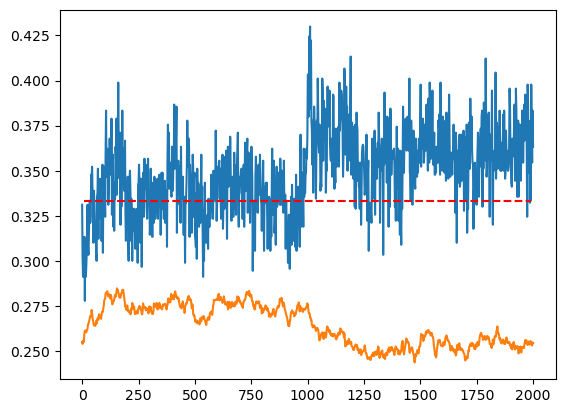

In [13]:
# obtain averages
lattice_av = np.mean(all_states,axis=(-1,-2))

ensemble_av = np.mean(lattice_av,axis=1)

ensemble_av.shape

plt.plot(t_grid,0.5*(ensemble_av[0,:]+1))
plt.plot(t_grid,ensemble_av[1,:])
plt.axhline(y=1/3,xmin=0.05,xmax=0.95,color='r',ls='--')
plt.show()

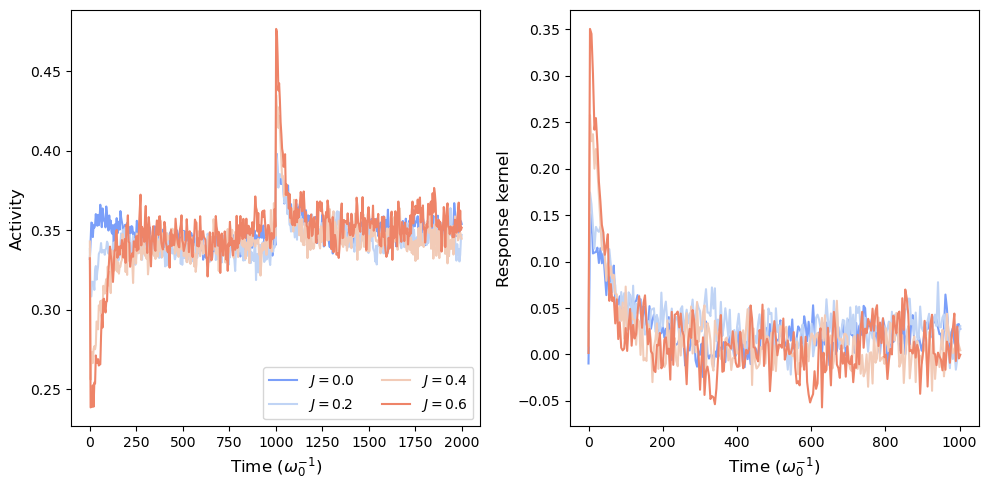

In [14]:
# function for finding response from a given ensemble
def adaptive_response_finder(all_act,step_change,time,cnew,c=100,co=1000):
    # extract mean as a function of time
    activity = np.mean(all_act,axis=(0,-1,-2))
    
    # find response and shift time
    baseline = np.mean(activity[step_change-co:step_change])
    response = (activity[step_change-1:] - baseline)/np.log(c/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sds = np.std(all_act[:,step_change-1:,:,:],axis=(0,-1,-2))/np.log(c/cnew)
    
    return response, sds, shifted_time

# parameters
n_samples = 1000
tf = 2000
n_steps = 500
step_change = 250
co = 50
L = 3
kR = 0.01
cnew = 70

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

for J in [0.,0.2,0.4,0.6]:
    # obtain results
    all_states, t_grid = ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,cnew=cnew,step_change=step_change)

    # convert to activity 
    all_act = 0.5*(all_states[0] + 1)

    ax1.plot(t_grid,np.mean(all_act,axis=(0,-1,-2)),label=f'$J={J}$',color=colormap(J+0.2))
    
    # extract response
    response, sds, shifted_time = adaptive_response_finder(all_act,step_change,t_grid,cnew,co=co)
    ax2.plot(shifted_time,response,color=colormap(J+0.2))

ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.legend(fontsize=10,ncol=2)

ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_ylabel('Response kernel',size=12)

plt.tight_layout()
plt.show()

Done for L =  2
Done for L =  4
Done for L =  6


/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done for L =  8
Done for L =  10


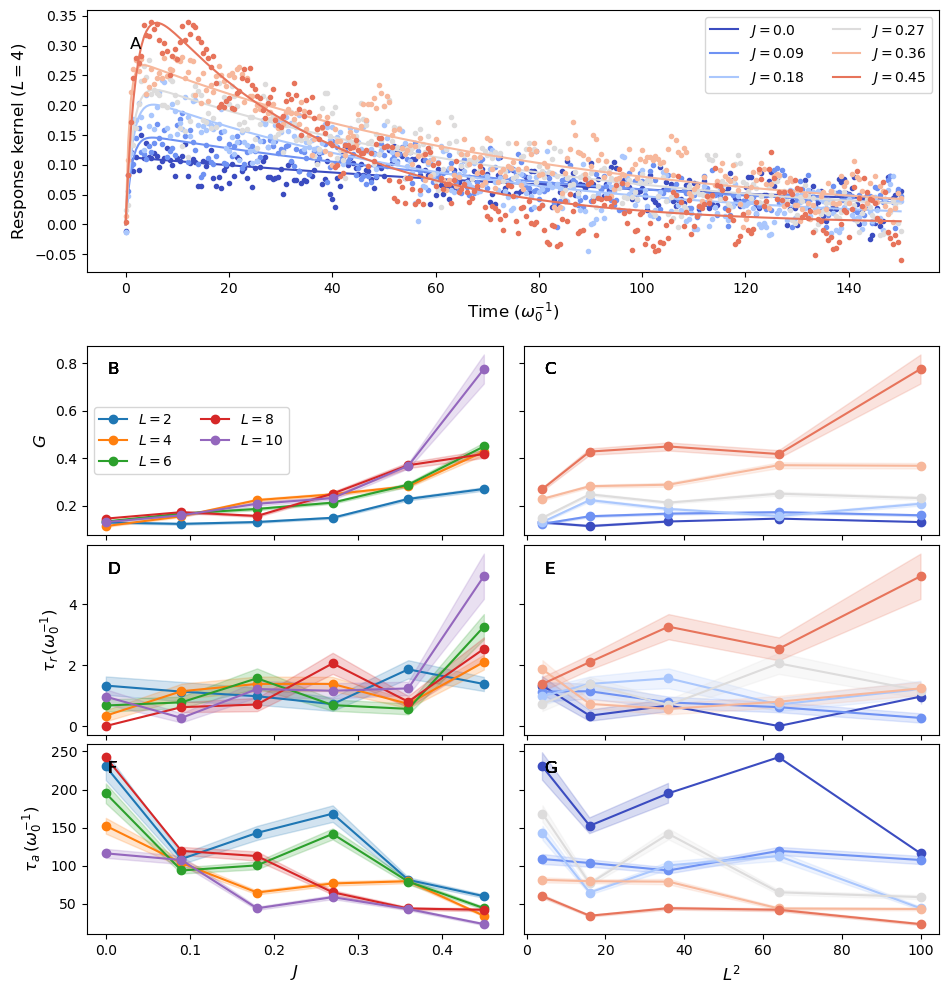

In [27]:
# adaptive response kernel
def K(time,G,tau_r,tau_a):
    return G*(1-np.exp(-time/tau_r))*np.exp(-time/tau_a)

# quantify how the gain and response time depend on J
J_arr = np.linspace(0.0,0.45,6)
L_arr = np.arange(2,11,2)
    
#n_samples = 3000
tf = 1500
n_steps = 3000
step_change = 2700
co = 100
kR = 0.008
cnew = 90

# prep
K_parms = np.zeros((3,L_arr.size,J_arr.size),dtype='float32')
K_sds = np.zeros_like(K_parms)

fig = plt.figure(figsize=(11,12))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(bottom=0.4)
ax1 = fig.add_subplot(gs1[0,:])

gs2 = gridspec.GridSpec(3, 2)
gs2.update(top=0.6, hspace=0.05, wspace=0.05)

ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[0,1], sharey = ax2)
ax4 = fig.add_subplot(gs2[1,0],sharex = ax2)
ax5 = fig.add_subplot(gs2[1,1],sharex = ax3, sharey = ax4)
ax6 = fig.add_subplot(gs2[2,0],sharex = ax2)
ax7 = fig.add_subplot(gs2[2,1],sharex = ax3,sharey = ax6)

text_list_1 = ['B','D','F']
text_list_2 = ['C','E','G']

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # obtain results
        n_samples = 30000//L**2
        all_states, t_grid = ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,cnew=cnew,step_change=step_change)

        # convert to activity 
        all_act = 0.5*(all_states[0] + 1)

        # extract response
        response, sds, shifted_time = adaptive_response_finder(all_act,step_change,t_grid,cnew,co=co)

        # fit
        popt, pcov = curve_fit(K,shifted_time,response,p0=[1,1,100],sigma=sds,maxfev=1500)
        K_parms[:,l,j] = popt
        K_sds[:,l,j] = [np.sqrt(pcov[i,i]) for i in range(3)]

        # show response kernels only for one value of L
        if l == 1:
            ax1.plot(shifted_time,response,'.',color=colormap(j/J_arr.size))
            ax1.plot(shifted_time,K(shifted_time,*popt),
                     color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
            
    # show how the gain and time scales depend on J
    for i,ax in enumerate((ax2,ax4,ax6)):
        ax.plot(J_arr,K_parms[i,l,:],'-o',color=colormap_aux(l),label=f'$L={L}$')
        ax.fill_between(J_arr,K_parms[i,l,:]-K_sds[i,l,:],K_parms[i,l,:]+K_sds[i,l,:],
                        alpha=0.2,color=colormap_aux(l))
        ax.text(0.05,0.85,text_list_1[i],size=12,transform = ax.transAxes)
        
    print('Done for L = ',L)
    
# show how the gain and time scales depend on L at a specific J
for i,ax in enumerate((ax3,ax5,ax7)):
    for j,J in enumerate(J_arr):
        ax.plot(L_arr**2,K_parms[i,:,j],'-o',color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
        ax.fill_between(L_arr**2,K_parms[i,:,j]-K_sds[i,:,j],K_parms[i,:,j]+K_sds[i,:,j],
                        alpha=0.2,color=colormap(j/J_arr.size))
        ax.text(0.05,0.85,text_list_2[i],size=12,transform = ax.transAxes)

# formatting
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel(f'Response kernel ($L={L_arr[1]}$)',size=12)
ax1.legend(ncol=2,fontsize=10)
ax1.text(0.05,0.85,'A',size=12,transform = ax1.transAxes)

ax2.set_ylabel(r'$G$',size=12)
ax2.legend(loc='center left',ncol=2,fontsize=10)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

#ax4.set_yscale('log')
ax4.set_ylabel(r'$\tau_r \, (\omega_0^{-1})$',size=12)
plt.setp(ax4.get_xticklabels(), visible=False)

#ax5.set_yscale('log')
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)

#ax6.set_yscale('log')
ax6.set_ylabel(r'$\tau_a \, (\omega_0^{-1})$',size=12)
ax6.set_xlabel(r'$J$',size=12)

#ax7.set_yscale('log')
ax7.set_xlabel(r'$L^2$',size=12)
plt.setp(ax7.get_yticklabels(), visible=False)

plt.show()

### Noise kernel

In [19]:
# function for finding several realisations of single-cell activity
@numba.jit(nopython=True)
def activity_finder_meth(n_steps,tf,n_samples,Nc,L,J,kR):
    # array to save results
    all_act = np.zeros((n_steps,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        all_states, time = ensemble_averaged_meth(Nc,n_steps,tf,L,J,kR)
        cell_av = 0.5*(np.sum(all_states[0],axis=0)/all_states[0,:,0,0,0].size + 1)
        
        # extract activity
        all_act[:,sample] = lattice_mean(cell_av)
        
    return all_act, time

Parameters of best fit: [sigma_n, tau_n] = [ 0.13133726 50.11862754]


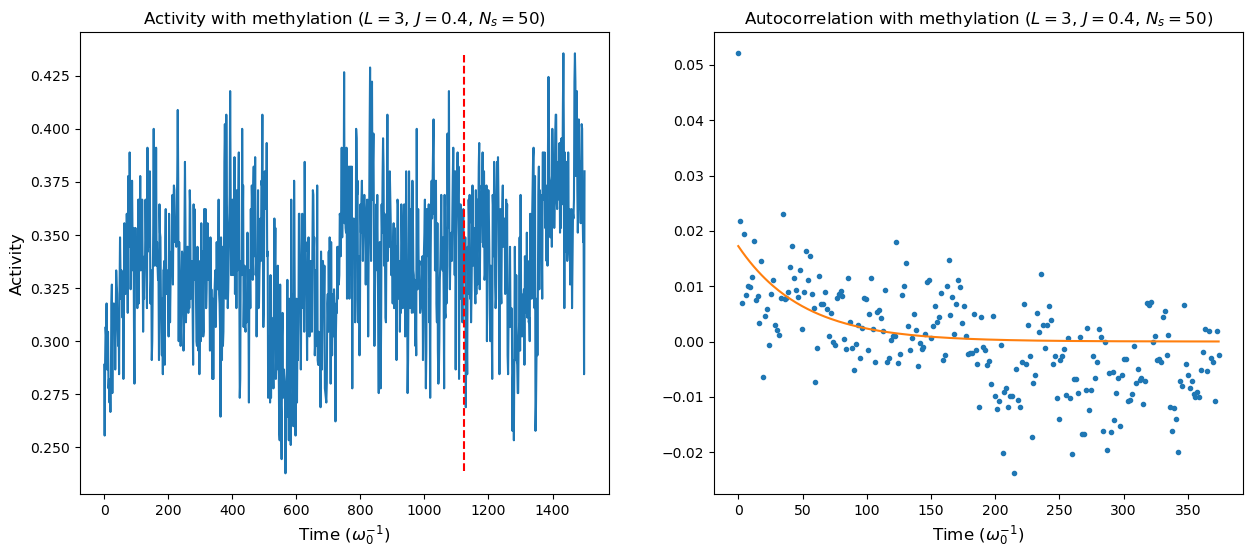

In [20]:
# parameters
n_samples = 50
Nc = 1
tf = 1500
n_steps = 1000
co = 750
kR = 0.008
J = 0.4
L = 3

# obtain activities
all_act, time = activity_finder_meth(n_steps,tf,n_samples,Nc,L,J,kR)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(time,np.mean(all_act,axis=1))
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Activity with methylation $(L={L},\, J={J},\, N_s={n_samples})$')
ax1.axvline(x=tf*co/n_steps,ymin=0.05,ymax=0.95,color='r',linestyle='--')

# fitting function
def noise_kernel(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

popt, pcov = curve_fit(noise_kernel,time_s,auto_corr)

# show the data with fit
print('Parameters of best fit: [sigma_n, tau_n] =', popt)

ax2.plot(time_s,auto_corr,'.')
ax2.plot(time_s,noise_kernel(time_s,*popt))
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Autocorrelation with methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

plt.show()

Done for L =  3
Done for L =  4
Done for L =  5
Done for L =  6
Done for L =  7
Done for L =  8


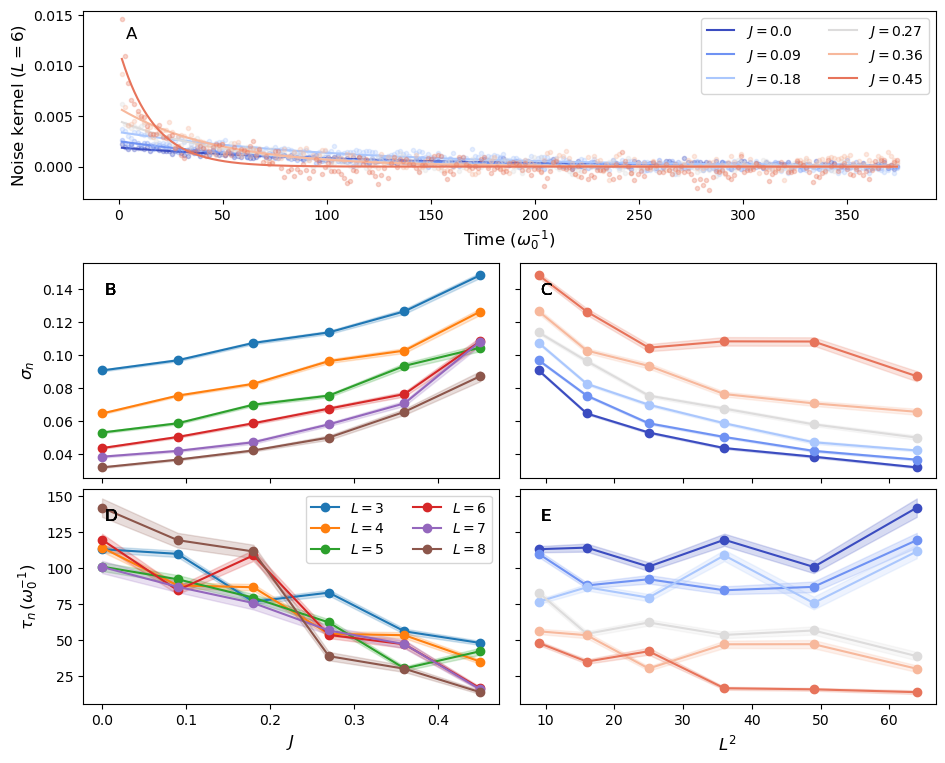

In [26]:
# quantify how the noise amplitude and time depend on J
J_arr = np.linspace(0.,0.45,6)
L_arr = np.arange(3,9)
    
# parameters
#n_samples = 3000
Nc = 1
tf = 1500
n_steps = 1000
co = 750
kR = 0.008

# prep
anoise_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float32')
anoise_sds = np.zeros_like(anoise_parms)

fig = plt.figure(figsize=(11,9))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(bottom=0.42)
ax1 = fig.add_subplot(gs1[0,:])

gs2 = gridspec.GridSpec(2, 2)
gs2.update(top=0.6, hspace=0.05, wspace=0.05)

ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[0,1], sharey = ax2)
ax4 = fig.add_subplot(gs2[1,0],sharex = ax2)
ax5 = fig.add_subplot(gs2[1,1],sharex = ax3, sharey = ax4)

text_list_1 = ['B','D','F']
text_list_2 = ['C','E','G']

for l,L in enumerate(L_arr):
    for j,J in enumerate(J_arr):
        # obtain activities
        n_samples = 30000//L**2
        all_act, time = activity_finder_meth(n_steps,tf,n_samples,Nc,L,J,kR)

        # obtain autocorrelation
        auto_corr, time_s = autocorr(all_act,time,co)

        # fitting; ignore the point at time zero for the fit only
        popt, pcov = curve_fit(noise_kernel,time_s[1:],auto_corr[1:])
        anoise_parms[:,l,j] = popt
        anoise_sds[:,l,j] = [np.sqrt(pcov[i,i]) for i in range(2)]

        # show noise kernels only for one value of L
        if l == 3:
            ax1.plot(time_s[1:],auto_corr[1:],'.',color=colormap(j/J_arr.size),alpha=0.3)
            ax1.plot(time_s[1:],noise_kernel(time_s[1:],*popt),
                     color=colormap(j/J_arr.size),label=f'$J={np.round(J,2)}$')
            
    # show how the noise amplitude and time depend on J
    for i,ax in enumerate((ax2,ax4)):
        ax.plot(J_arr,anoise_parms[i,l,:],'-o',color=colormap_aux(l),label=f'$L={L}$')
        ax.fill_between(J_arr,anoise_parms[i,l,:]-anoise_sds[i,l,:],anoise_parms[i,l,:]+anoise_sds[i,l,:],
                        alpha=0.2,color=colormap_aux(l))
        ax.text(0.05,0.85,text_list_1[i],size=12,transform = ax.transAxes)
        
    print('Done for L = ',L)
    
# show how the noise amplitude and time depend on L at a specific J
for i,ax in enumerate((ax3,ax5)):
    for j,J in enumerate(J_arr):
        ax.plot(L_arr**2,anoise_parms[i,:,j],'-o',color=colormap(j/J_arr.size),label=f'$L={L}$')
        ax.fill_between(L_arr**2,anoise_parms[i,:,j]-anoise_sds[i,:,j],anoise_parms[i,:,j]+anoise_sds[i,:,j],
                        alpha=0.2,color=colormap(j/J_arr.size))
        ax.text(0.05,0.85,text_list_2[i],size=12,transform = ax.transAxes)
        

# formatting
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel(f'Noise kernel ($L={L_arr[3]}$)',size=12)
ax1.legend(loc='upper right',ncol=2,fontsize=10)
ax1.text(0.05,0.85,'A',size=12,transform = ax1.transAxes)

ax2.set_ylabel(r'$\sigma_n$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

# ax4.set_yscale('log')
ax4.set_ylabel(r'$\tau_n \, (\omega_0^{-1})$',size=12)
ax4.set_xlabel(r'$J$',size=12)
ax4.legend(loc='best',ncol=2,fontsize=10)

ax5.set_xlabel(r'$L^2$',size=12)
plt.setp(ax5.get_yticklabels(), visible=False)
# ax5.set_yscale('log')

plt.show()